# Imports and setup of experiment

In [1]:
#super basic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.random as random
import ipdb
import copy

#torch stuff
import torch
import pytorch_lightning as pl

#experiment stuff
from exp_lib.ecircuit2 import *

#analysis / software for ml
from ana_lib.custom_plmodels import *
from ana_lib.optuna_utils import *
from ana_lib.noise import *
from ana_lib.pat_utils import *
from ana_lib.pl_callbacks import *
from ana_lib.pl_utils import *
from ana_lib.plot_utils import *
from ana_lib.process_spectrum import *
from ana_lib.torch_loader import *
from ana_lib.utils import *
    
dirname = get_dirname()

C:\Users\jimiw\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
run_experiment

<function exp_lib.ecircuit2.run_experiment(x, board_num, ai_info, ai_range, ao_info, ao_range, A=1, B=0, OD=56, Tmax=600, st=660, Nde=450, input_pad=100, checklength=3000, trigger=0.05, outpad=3000, channel=0)>

In [3]:
#These need to be previously worked out using e.g. the testing below

input_dims=np.array([196,98,56,28,14])



output_dims=np.array([196,98,56,28,14])


In [4]:
board_num,ai_info,ai_range,ao_info,ao_range=setup_daq()

Found 1 DAQ device(s):
  USB-1208HS-4AO (1F0EBD7) - Device ID = 198


In [5]:
ai_info

In [6]:
# run setup functions!
from scipy.interpolate import interp1d


class PNNm():
    def __init__(self,board_num,ai_info,ai_range,ao_info,ao_range,xdim,A=1,B=0, Tmax=600, OD=56, st=660, Nde=400, adj_opt=1.0,
                 input_pad=50,trigger_level=0.5,check_mean=None,check_threshold=0,return_check=False,output_pad=3500,channel=0):
        self.A=A
        self.B=B
        self.Tmax=Tmax
        self.OD=OD
        self.st=st
        self.Nde=Nde
        self.adj_opt=adj_opt
        self.input_pad=input_pad
        self.board_num=board_num
        self.ai_info = ai_info
        self.ai_range = ai_range
        self.ao_info = ao_info
        self.ao_range = ao_range
        self.trigger_level=trigger_level
        self.check_mean = check_mean
        self.check_threshold = check_threshold
        self.return_check = return_check
        self.xdim=xdim
        random.seed(0)
        self.xcheck = random.uniform(-1.0, 1.0, [1, self.xdim])
        self.output_pad=output_pad
        self.channel=channel

    def __call__(self,x):
        
        x=x.detach().numpy() #MUST BE TENSOR INPUT!
        pm = random.permutation(len(x)+1)
        pminv = np.argsort(pm) #permute to avoid errors due to interference between runs
        x=np.vstack((x,self.xcheck))
        #print(x.shape)
        x=x[pm,:]
                  
        good=False #This is because every so often the DAQ fails to write correctly 
        while (good==False):
            #print(self.A)
            #print(self.B)
            out,outfull,rawout = run_experiment(x,self.board_num,self.ai_info,self.ai_range,self.ao_info,
                                         self.ao_range,A=self.A,B=self.B,OD=self.OD,Tmax=self.Tmax,
                                         st=self.st,Nde=self.Nde,input_pad=self.input_pad,checklength=5000,
                                         trigger=self.trigger_level,outpad=self.output_pad,channel=self.channel)
            if len(out) != x.shape[0]:
                print('Missed run')
                good = False
            else:
                try: 
                    out = np.array(out) 
                    out = torch.from_numpy(out*self.adj_opt).float()
                    outfull = np.array(outfull) 
                    #outfull[0,0]
                except: 
                    print('Missed run')
                    good = False
                else:
                    good = True
                    
            if good:
                outf = outfull[pminv,:]
                #outf = outfull
                check = outf[-1,:]
                check = check-np.mean(check)
                check = check/np.max(check)
            if good and (self.check_mean is not None):

                error = np.sum(np.abs(check-self.check_mean))
                if error > self.check_threshold:
                    good = False
                    #set_trace()
        out = out[pminv,:]
        if self.return_check:    
            return out[:-1,:],check,rawout
        else:
            return out[:-1,:]    
        
        
def get_check_mean_threshold(pnn,sample_size=1000,ratio=2,namex='',rangeA=-1.,rangeB=1.):
    pnn.return_check=True
    
    Nx=50
    xdim=pnn.xdim
    Tmax=pnn.Tmax
    xlist = torch.from_numpy(random.uniform(rangeA, rangeB, [Nx, xdim])).float()
    
    checks=list()
    outs=list()
    for r in range(sample_size):
        out,check = take_check_data(PNN_test,xlist)
        checks.append(check)
        outs.append(out) 
            
    checks = np.array(checks)
    check_mean = np.mean(checks,0)
    check_mean_mean = np.mean(check_mean)
    check_max = np.max(check_mean-check_mean_mean)
    check_mean = (check_mean-check_mean_mean)/check_max
    check_errors = np.sum(np.abs((checks[:,:]-check_mean_mean)/check_max-check_mean[:]),1)
    
    bins=np.linspace(np.min(check_errors),np.max(check_errors),sample_size//100)
    hist = np.histogram(check_errors,bins=bins)
    
    for idx in range(sample_size//100):
        if np.sum(hist[0][:idx])/sample_size > 1/ratio:
            threshold_idx = idx
            break
            
    check_threshold = bins[threshold_idx]
    np.savez('dt_data/Tmax'+str(pnn.Tmax)+'xdim'+str(xdim)+namex+'checkstuff.npz',check_threshold=check_threshold,check_mean=check_mean)
    
    outs = np.array(outs)
    outs = np.reshape(outs,[sample_size,Nx*pnn.Nde])
    out_mean = np.mean(outs,0)
    out_errors = np.sum(np.abs(outs-out_mean),1)
    
    plt.figure(figsize=[7,7])
    plt.subplot(2,1,1)
    plt.hist(check_errors,bins=bins)
    plt.plot(check_threshold,0,'ko')
    plt.xlabel('Error on check')
    plt.ylabel('Number of events')
    plt.subplot(2,1,2)
    plt.plot(check_errors,out_errors,'o')
    plt.xlabel('Check error')
    plt.ylabel('Output error')
    plt.savefig(f'dt_data/xdim{xdim}_Tmax{Tmax}_l1_check' +namex+'.png')
    plt.close()
    
    pnn.return_check=False
    
    return check_mean,check_threshold
    
        
def take_check_data(pnn,xlist, seed=0):
    exp_out,check_out=pnn(xlist)[0:2]
    return exp_out.detach().numpy(),check_out

def take_dt_data(pnn,xlist, Nrepeat, seed=0,batchsize=100):
    Nx=xlist.shape[0]
    xdim=xlist.shape[1]
    exp_out_list = []
    Nbatches = Nx//batchsize

    for i in range(Nrepeat):
        for ib in range(Nbatches):
            if ib>0:
                out_list=np.vstack((out_list,pnn(torch.from_numpy(xlist[ib*batchsize:(ib+1)*batchsize]).float()).detach().numpy()))
            else:
                out_list=pnn(torch.from_numpy(xlist[ib*batchsize:(ib+1)*batchsize]).float()).detach().numpy()

        exp_out_list.append(out_list)
    return xlist, exp_out_list

def save_dt_data(fname, xlist, specs_list):
    np.savez(fname, specs_list=specs_list, xlist=xlist)   

In [7]:
sts=np.array([260,268,280])
lens=np.array([52,70,105])
Tmaxs=np.array([75,100,150])

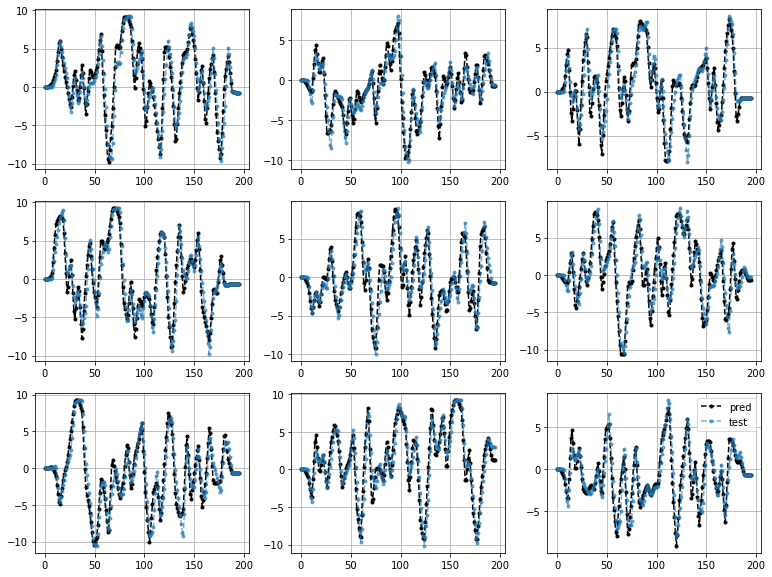

In [8]:
Nx = 150
xdim=49
PNN_test = PNNm(board_num,ai_info,ai_range,ao_info,ao_range,xdim,A=1,B=0, Tmax=Tmaxs[0], 
                OD=196, st=sts[0], Nde=lens[0],channel=0)

random.seed(0)
scale=1
xlist = random.uniform(-scale, scale, [Nx, xdim])

outs = take_dt_data(PNN_test,xlist,2,batchsize=50)[1]

plot_grid(outs[0][:, :], outs[1][:, :]);

# Take digital twin data

In [9]:
sts=np.array([260,268,280])
lens=np.array([52,70,105])
Tmaxs=np.array([75,100,150])

xdim_list=[49,70,98]

In [27]:
def lp_xlist(xdim, Nx, Nlp):
    xlist = random.uniform(0.0, 1.0, [Nx, xdim+Nlp-1])
    y = np.array([np.convolve(x, np.ones(Nlp)/Nlp, mode='valid') for x in xlist])
    y = 1.0*(y-0.5)*np.sqrt(Nlp) + 0.5
    y=y*2-1
    y=y*1.5 #to make it clip a bit more
    return y.clip(-1, 1)

def dt_inputs(Nx,xdim):
    
    #iid data
    xin=random.uniform(-1.5, 1.5, [Nx//10, xdim]).clip(-1,1) #First 10th just iid from -1 to 1
    rangetops = np.linspace(0.1,1,10)  #Next 4/10 do iid with various upper/lower ranges
    rangebottoms = np.linspace(0.1,1,10)
    for rangetop in rangetops:
        for rangebottom in rangebottoms:
            xin = np.vstack((xin,random.uniform(-rangebottom, rangetop, [4*Nx//1000, xdim])))     
    #low-pass/naturalized data
    xin = np.vstack((xin,lp_xlist(xdim,Nx//10,2)))
    xin = np.vstack((xin,lp_xlist(xdim,Nx//10,3)))
    xin = np.vstack((xin,lp_xlist(xdim,Nx//10,5)))
    xin = np.vstack((xin,lp_xlist(xdim,Nx//10,8)))
    xin = np.vstack((xin,lp_xlist(xdim,Nx//10,16)))  
    
    pm = random.permutation(len(xin))
    xin=xin[pm,:]   
    return xin

49
75
Done Check tests
6.629274139273821
PNN failed
Missed run
Wall time: 6min 33s
40
(3000, 52)
Wall time: 6min 32s
2
(60000, 52)
70
75
Done Check tests
5.18574711554537
PNN failed
Missed run
Wall time: 5min 26s
40
(3000, 52)
PNN failed
Missed run
Wall time: 5min 31s
2
(60000, 52)
98
75
Done Check tests
6.480311734521408
Wall time: 5min 24s
40
(3000, 52)
PNN failed
Missed run
Wall time: 5min 39s
2
(60000, 52)
49
100
Done Check tests
8.363654517018011
Wall time: 5min 39s
40
(3000, 70)
Wall time: 5min 36s
2
(60000, 70)
70
100
Done Check tests
9.573766054337323
Wall time: 5min 6s
40
(3000, 70)
Wall time: 5min 2s
2
(60000, 70)
98
100
Done Check tests
8.67794296871995
PNN failed
Missed run
Wall time: 5min 37s
40
(3000, 70)
Wall time: 5min 46s
2
(60000, 70)


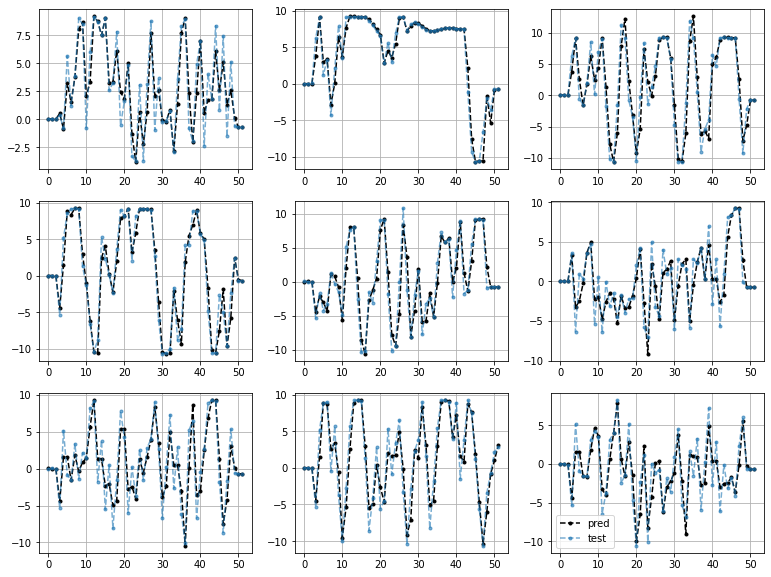

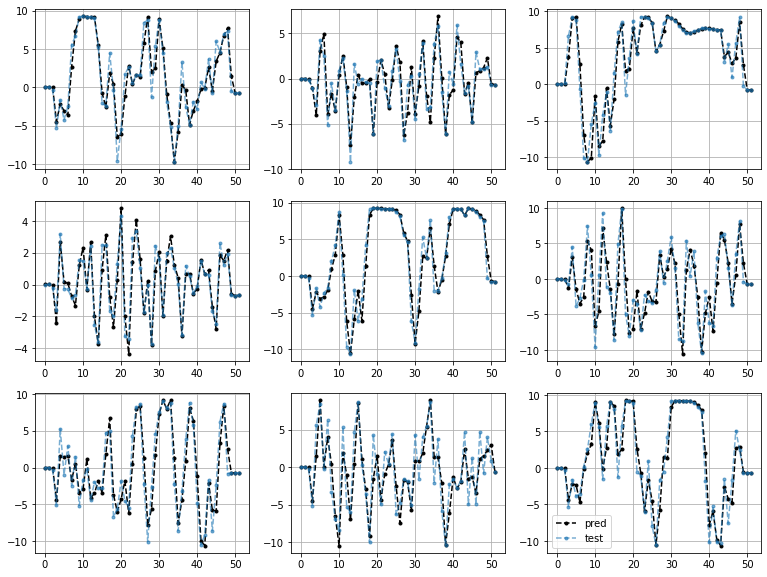

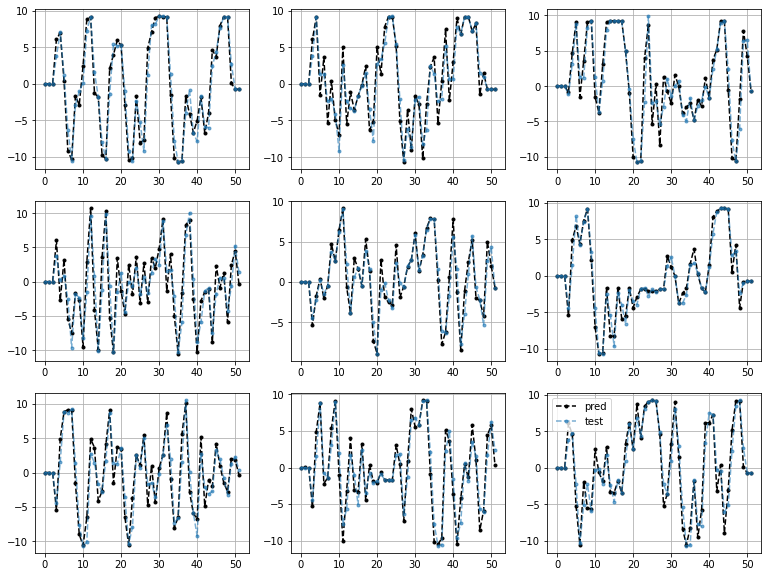

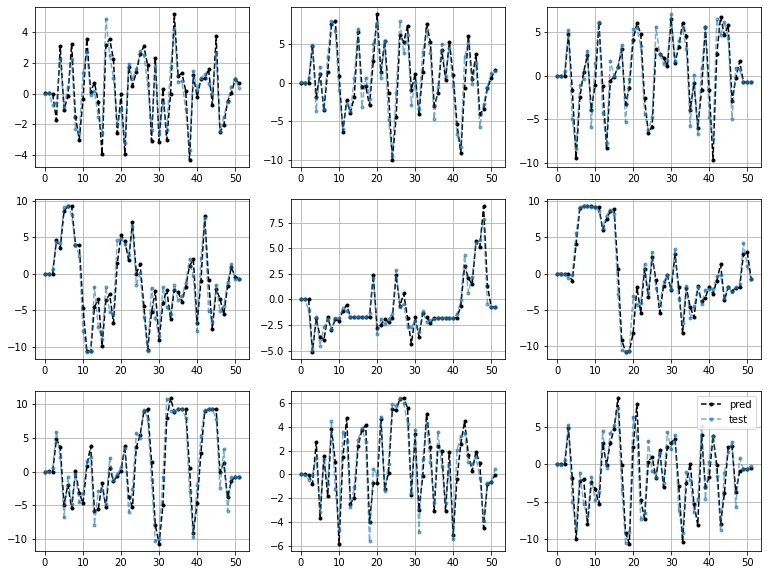

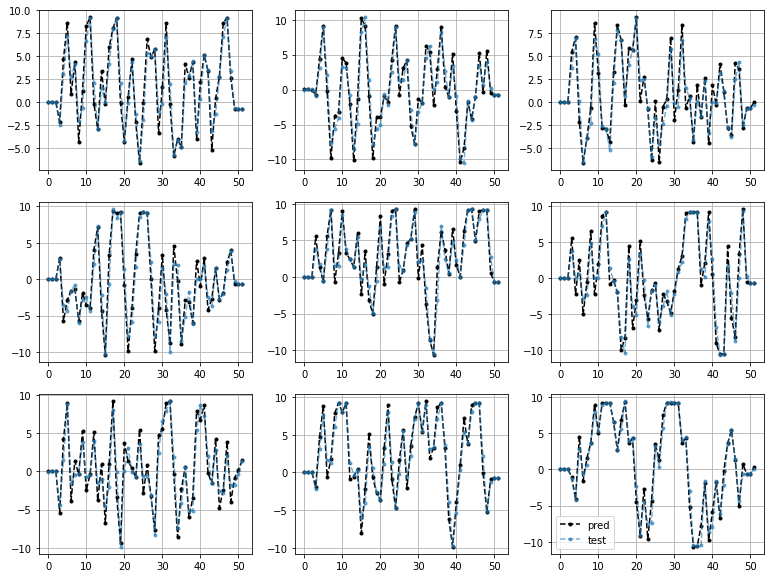

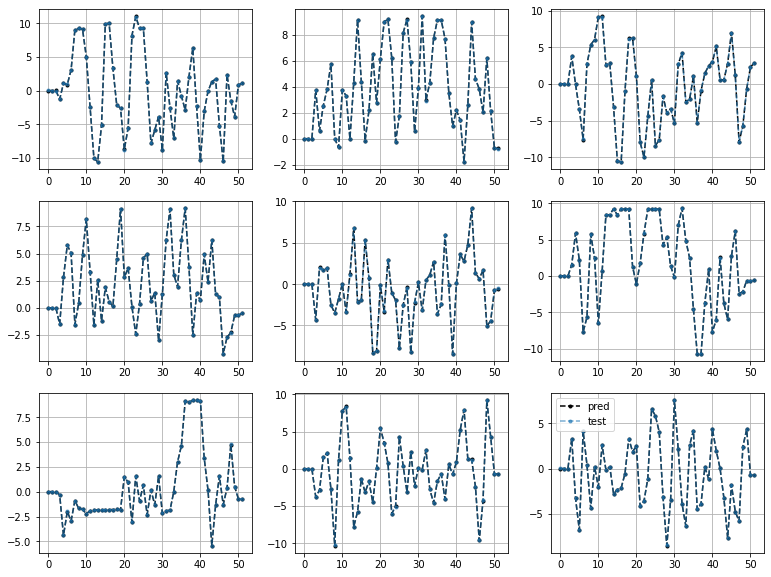

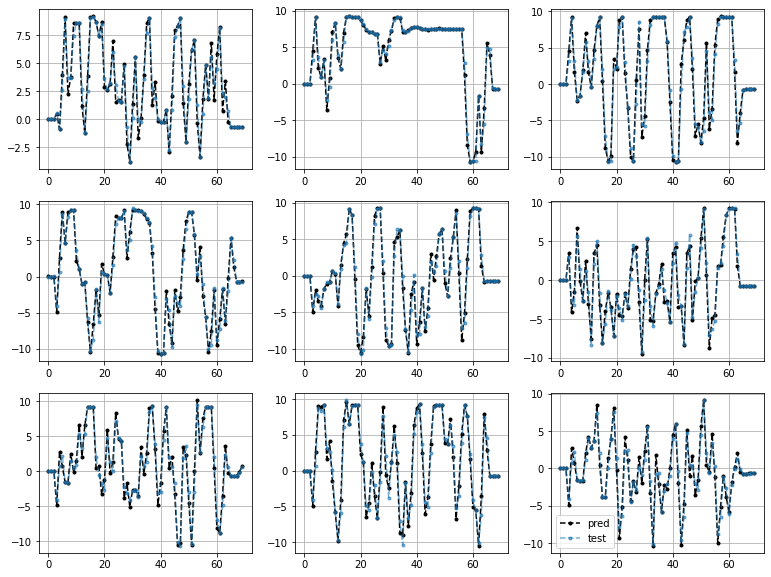

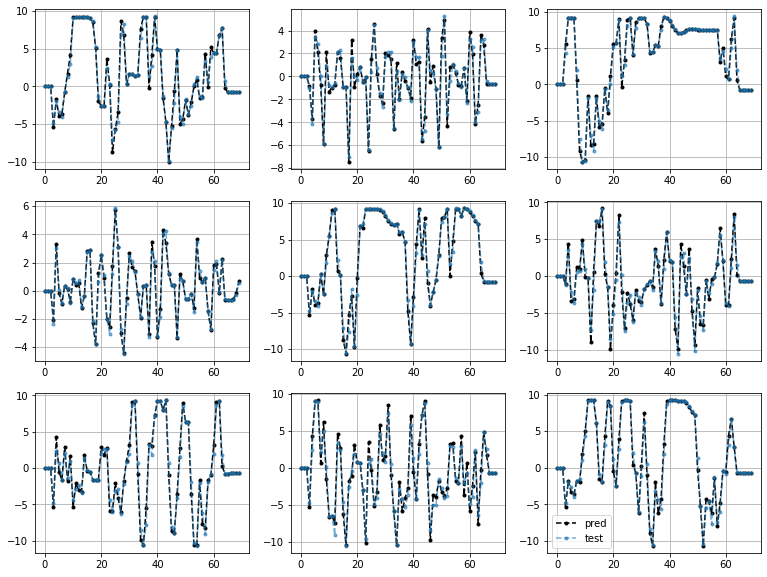

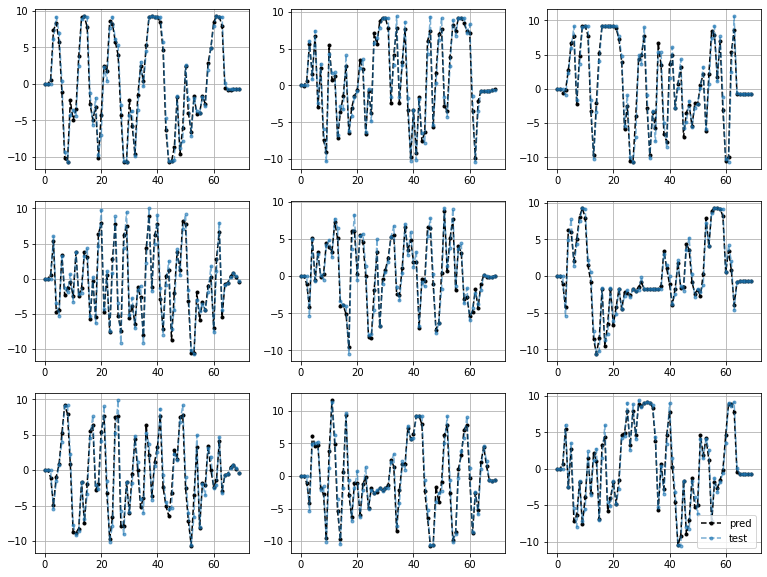

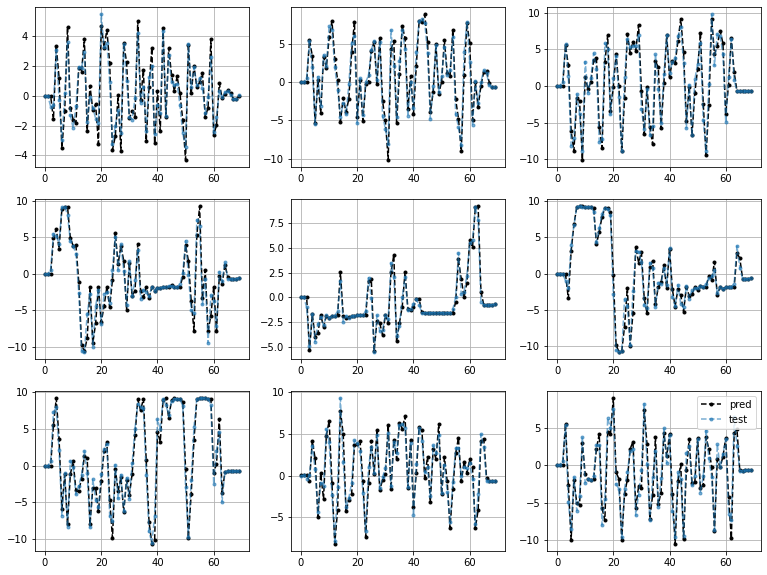

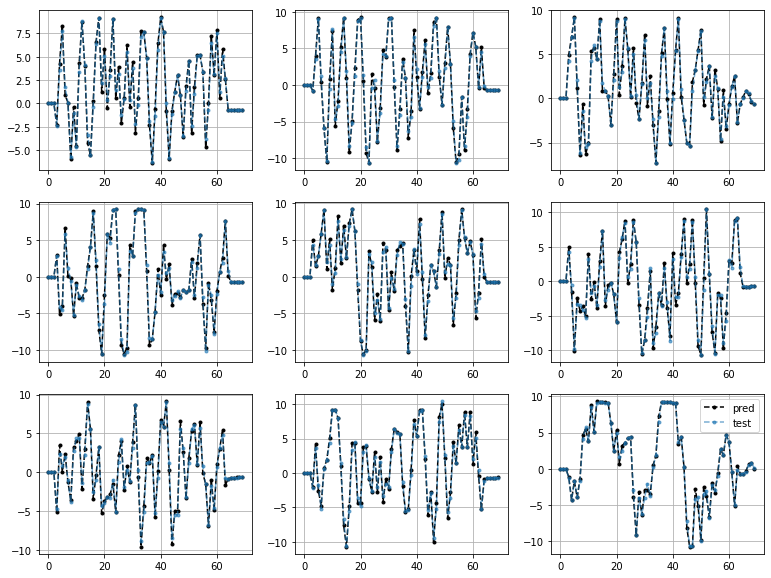

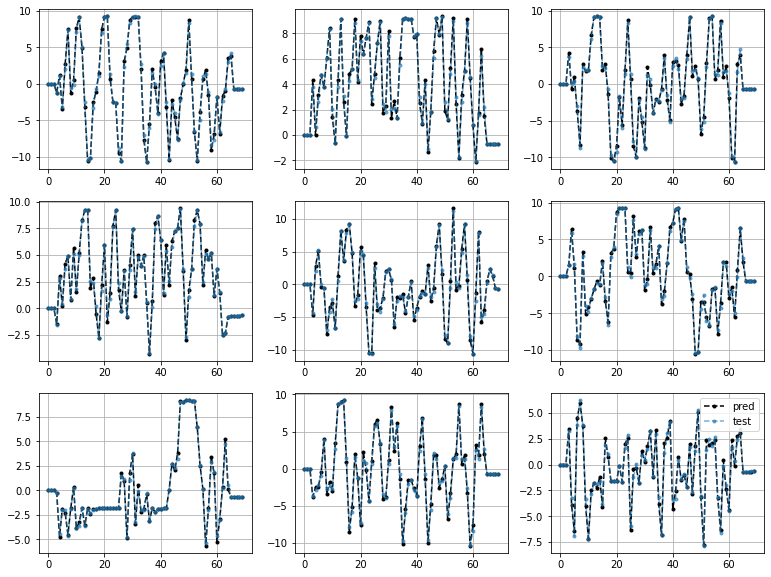

In [28]:
input_pad=20
trigger_level=0.5
output_pad = 3500
channel=0

#Digital twin data for the deeper layers
check_thresholds=list()
check_means=list()
seed=1
for idt in range(2):
    Tmax = Tmaxs[idt]
    for xdim in xdim_list:        
        print(xdim)
        print(Tmax)
        PNN_test = PNNm(board_num,ai_info,ai_range,ao_info,ao_range,xdim,A=1,B=0, Tmax=Tmaxs[idt], 
                OD=None, st=sts[idt], Nde=lens[idt],input_pad=input_pad,trigger_level=trigger_level,output_pad=output_pad,channel=channel)
        
        check_mean,check_threshold=get_check_mean_threshold(PNN_test,sample_size=2000,ratio=2,namex='l0',rangeA=-1.,rangeB=1.)
        PNN_test.check_mean=check_mean
        PNN_test.check_threshold=check_threshold
        
        check_thresholds.append(check_threshold)
        check_means.append(check_mean)
        print('Done Check tests')
        print(check_threshold)
               
        Nx = 3000
        Nrepeat = 40

        random.seed(seed)
        xin = dt_inputs(Nx,xdim)

        PNN_test.return_check=False
        
        %time xlist, specs_list = take_dt_data(PNN_test,xin, Nrepeat,batchsize=100)
        print(len(specs_list))
        print(specs_list[0].shape)
        np.savez(f"dt_data/xdim{xdim}_Tmax{Tmax}_l0_noise_data.npz", specs_list=specs_list, xlist=xlist)
        plot_grid(specs_list[0][:,:], specs_list[1][:,:]);

        #mean digital twin data
        Nx = 60000
        Nrepeat = 2

        random.seed(seed)
        xin = dt_inputs(Nx,xdim)

        %time xlist, specs_list = take_dt_data(PNN_test,xin, Nrepeat,batchsize=100)
        print(len(specs_list))
        print(specs_list[0].shape)
        np.savez(f"dt_data/xdim{xdim}_Tmax{Tmax}_l0_mean_data.npz", specs_list=specs_list, xlist=xlist)

        plot_grid(specs_list[0][:,:], specs_list[1][:,:]);

49
100
Done Check tests
8.363834474613691
Wall time: 5min 41s
40
(3000, 70)
PNN failed
Missed run
Wall time: 5min 59s
2
(60000, 70)
70
100
Done Check tests
8.61460182420754
Wall time: 5min 48s
40
(3000, 70)
Wall time: 5min 55s
2
(60000, 70)
98
100
Done Check tests
10.752386620582357
Wall time: 4min 40s
40
(3000, 70)
PNN failed
Missed run
Wall time: 4min 53s
2
(60000, 70)


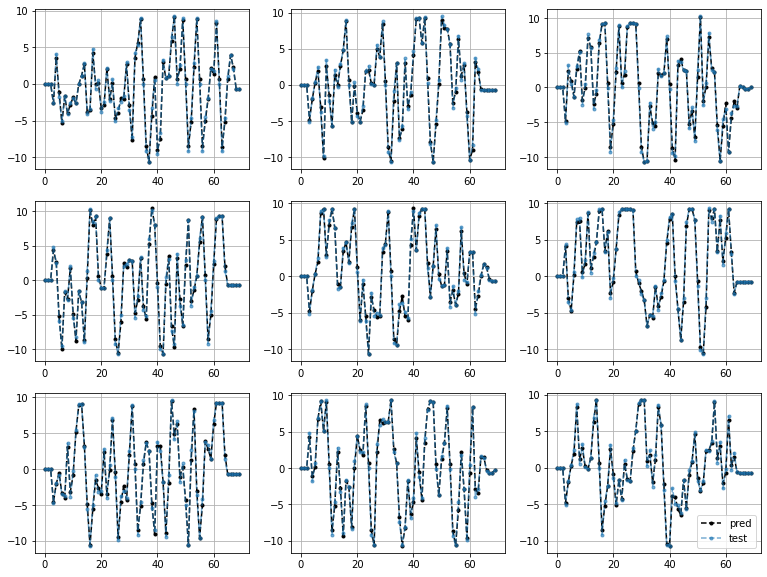

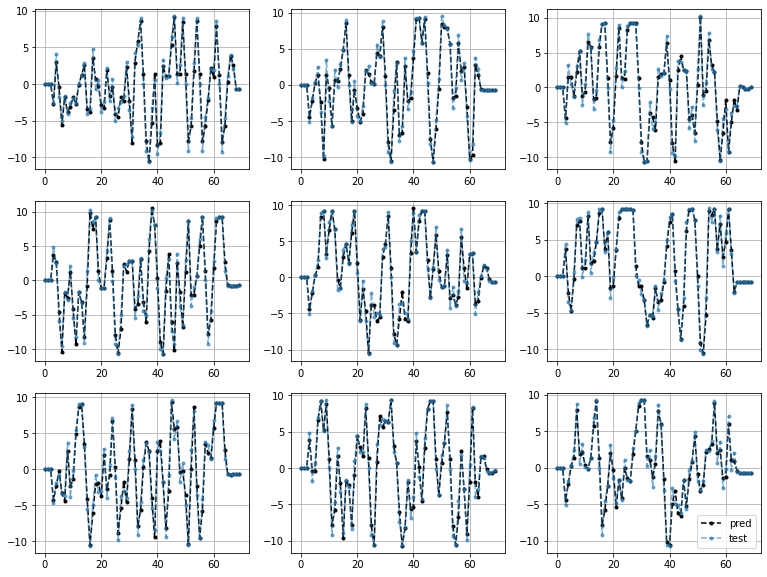

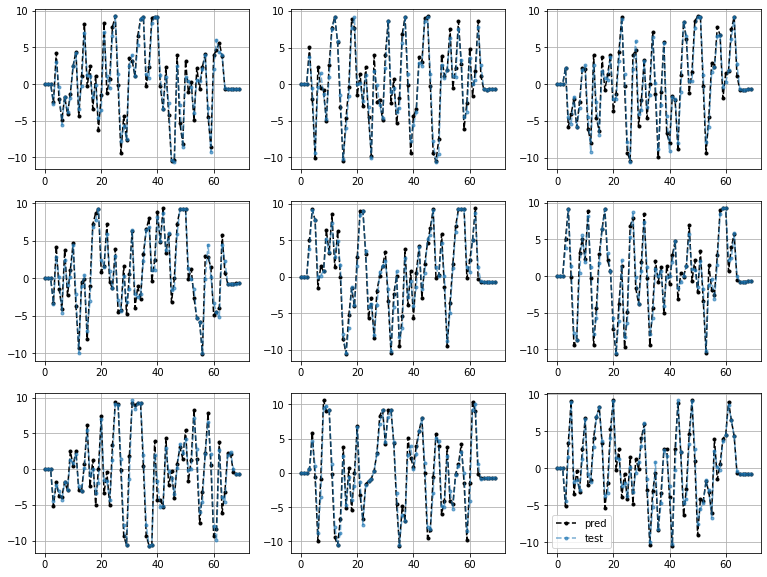

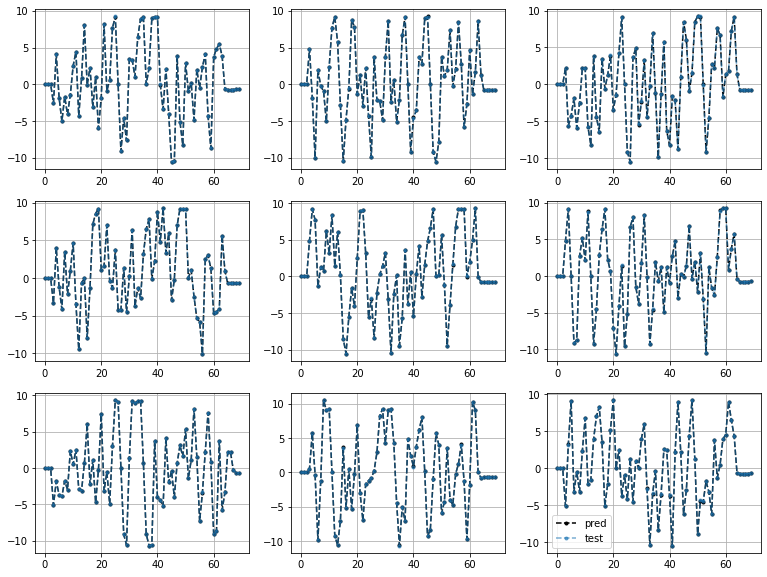

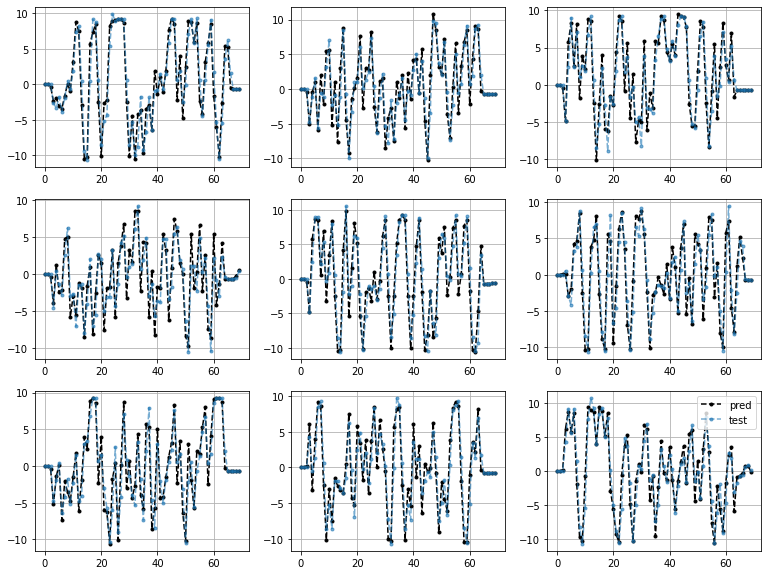

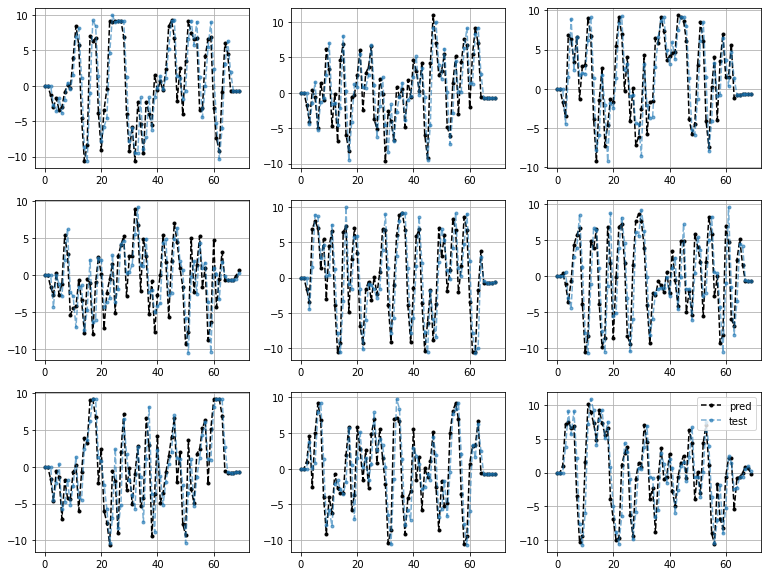

In [29]:
#Digital twin data for the deeper layers
check_thresholds=list()
check_means=list()
seed=1
for idt in range(1,2):
    Tmax = Tmaxs[idt]
    for xdim in xdim_list:        
        print(xdim)
        print(Tmax)
        PNN_test = PNNm(board_num,ai_info,ai_range,ao_info,ao_range,xdim,A=1,B=0, Tmax=Tmaxs[idt], 
                OD=None, st=sts[idt], Nde=lens[idt],input_pad=input_pad,trigger_level=trigger_level,output_pad=output_pad,channel=channel)
        
        check_mean,check_threshold=get_check_mean_threshold(PNN_test,sample_size=2000,ratio=2,namex='l0iid',rangeA=-1.,rangeB=1.)
        PNN_test.check_mean=check_mean
        PNN_test.check_threshold=check_threshold
        
        check_thresholds.append(check_threshold)
        check_means.append(check_mean)
        print('Done Check tests')
        print(check_threshold)
               
        Nx = 3000
        Nrepeat = 40

        random.seed(seed)
        xin = random.uniform(-1.3, 1.3, [Nx, xdim]).clip(-1,1)

        PNN_test.return_check=False
        
        %time xlist, specs_list = take_dt_data(PNN_test,xin, Nrepeat,batchsize=100)
        print(len(specs_list))
        print(specs_list[0].shape)
        np.savez(f"dt_data/xdim{xdim}_Tmax{Tmax}_l0iid_noise_data.npz", specs_list=specs_list, xlist=xlist)
        plot_grid(specs_list[0][:,:], specs_list[1][:,:]);

        #mean digital twin data
        Nx = 60000
        Nrepeat = 2

        random.seed(seed)
        xin = random.uniform(-1.3, 1.3, [Nx, xdim]).clip(-1,1)

        %time xlist, specs_list = take_dt_data(PNN_test,xin, Nrepeat,batchsize=100)
        print(len(specs_list))
        print(specs_list[0].shape)
        np.savez(f"dt_data/xdim{xdim}_Tmax{Tmax}_l0iid_mean_data.npz", specs_list=specs_list, xlist=xlist)

        plot_grid(specs_list[0][:,:], specs_list[1][:,:]);

49
75
Done Check tests
7.400670704334063
Wall time: 5min 20s
40
(3000, 52)
Wall time: 5min 24s
2
(60000, 52)
70
75
Done Check tests
5.389634263576154
Wall time: 4min 50s
40
(3000, 52)
Wall time: 4min 58s
2
(60000, 52)
98
75
Done Check tests
6.566446600883058
PNN failed
Missed run
Wall time: 5min 39s
40
(3000, 52)
Wall time: 5min 23s
2
(60000, 52)


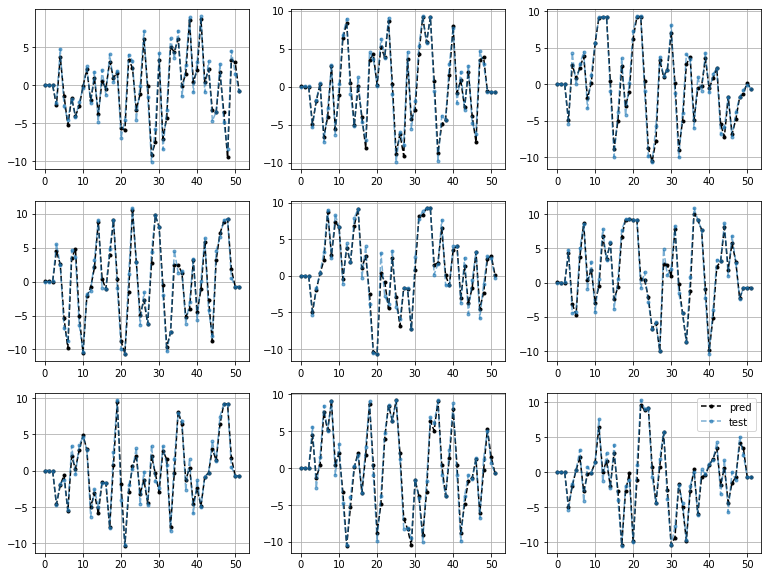

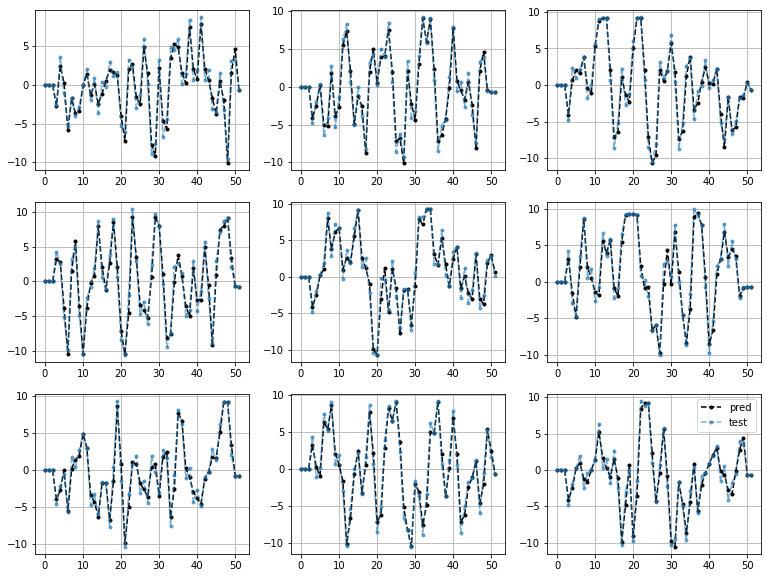

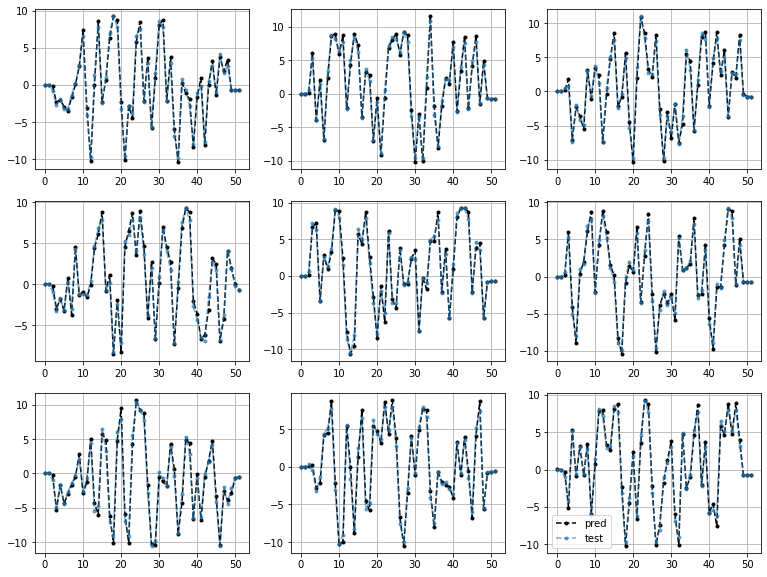

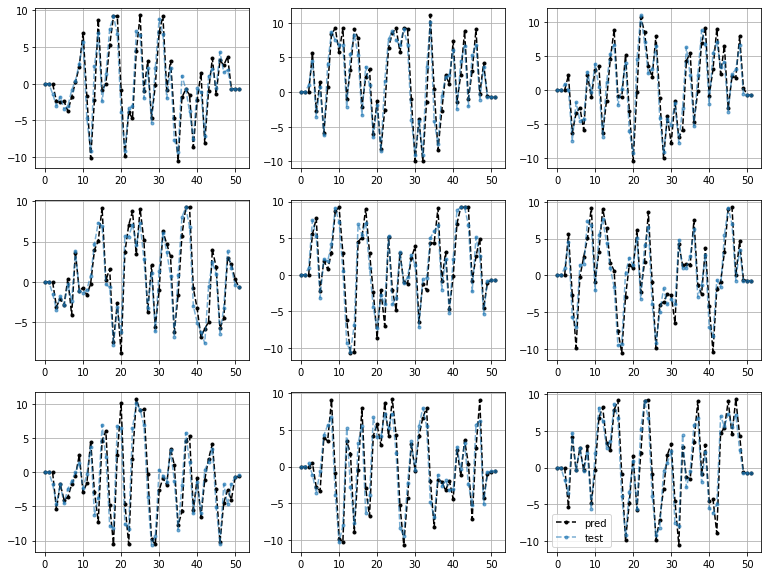

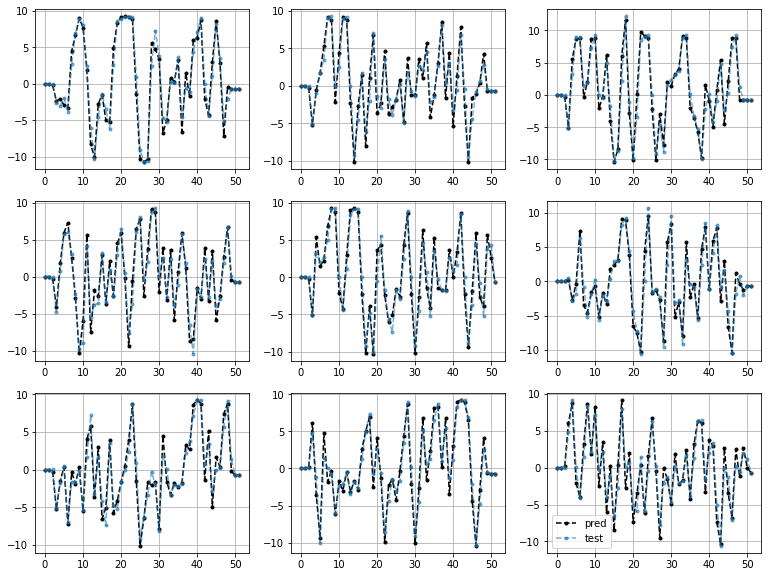

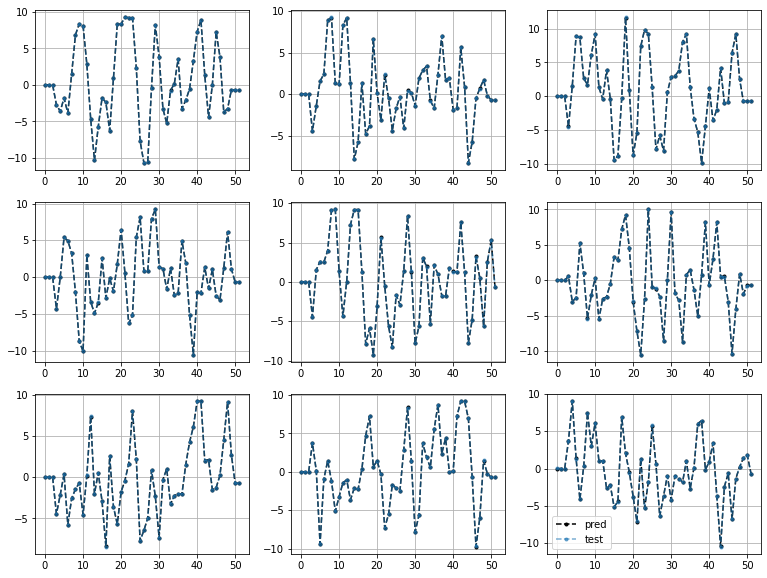

In [30]:
#Digital twin data for the deeper layers
check_thresholds=list()
check_means=list()
seed=1
for idt in range(1):
    Tmax = Tmaxs[idt]
    for xdim in xdim_list:        
        print(xdim)
        print(Tmax)
        PNN_test = PNNm(board_num,ai_info,ai_range,ao_info,ao_range,xdim,A=1,B=0, Tmax=Tmaxs[idt], 
                OD=None, st=sts[idt], Nde=lens[idt],input_pad=input_pad,trigger_level=trigger_level,output_pad=output_pad,channel=channel)
        
        check_mean,check_threshold=get_check_mean_threshold(PNN_test,sample_size=2000,ratio=2,namex='l0iid',rangeA=-1.,rangeB=1.)
        PNN_test.check_mean=check_mean
        PNN_test.check_threshold=check_threshold
        
        check_thresholds.append(check_threshold)
        check_means.append(check_mean)
        print('Done Check tests')
        print(check_threshold)
               
        Nx = 3000
        Nrepeat = 40

        random.seed(seed)
        xin = random.uniform(-1.3, 1.3, [Nx, xdim]).clip(-1,1)

        PNN_test.return_check=False
        
        %time xlist, specs_list = take_dt_data(PNN_test,xin, Nrepeat,batchsize=100)
        print(len(specs_list))
        print(specs_list[0].shape)
        np.savez(f"dt_data/xdim{xdim}_Tmax{Tmax}_l0iid_noise_data.npz", specs_list=specs_list, xlist=xlist)
        plot_grid(specs_list[0][:,:], specs_list[1][:,:]);

        #mean digital twin data
        Nx = 60000
        Nrepeat = 2

        random.seed(seed)
        xin = random.uniform(-1.3, 1.3, [Nx, xdim]).clip(-1,1)

        %time xlist, specs_list = take_dt_data(PNN_test,xin, Nrepeat,batchsize=100)
        print(len(specs_list))
        print(specs_list[0].shape)
        np.savez(f"dt_data/xdim{xdim}_Tmax{Tmax}_l0iid_mean_data.npz", specs_list=specs_list, xlist=xlist)

        plot_grid(specs_list[0][:,:], specs_list[1][:,:]);

## Train for task

Set up data


In [9]:
sts=np.array([260,268,280])
lens=np.array([52,70,105])
Tmaxs=np.array([75,100,150])

In [10]:
np.random.seed(0)
pm = np.random.permutation(10000)
batch_size = 100
from torchvision.datasets import MNIST
import torch
from torchvision import transforms
compress_factor = 2
reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))
transforms_noise = transforms.Compose([transforms.RandomAffine(15, translate=(0.0, 0.05), scale=(0.9, 1.1)), transforms.ToTensor(),  reshape_f])
train_loader = torch.utils.data.DataLoader(MNIST('..', train=True, download=True, transform=transforms_noise), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(MNIST('..', train=False, download=True), batch_size=batch_size, shuffle=True) 
v = val_loader.dataset.data
x = v[:, ::compress_factor, ::compress_factor]
x = x.reshape(x.shape[0], x.shape[1]**2)
y = val_loader.dataset.targets
yn = np.array(y)[pm]
xn = np.array(x)[pm]
xn = xn*1.0/255
Nval = 5000
Ntest = (xn.shape[1]-Nval)
Xv = xn[:Nval,:]
Xtest = xn[Nval:,:]
Yv = yn[:Nval]
Ytest = yn[Nval:]
val_dataset = TensorDataset(torch.tensor(Xv).float(), torch.tensor(Yv))
test_dataset = TensorDataset(torch.tensor(Xtest).float(), torch.tensor(Ytest))
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [11]:
def relu_approx(x, factor=20.0):
    """
    A soft-relu function
    The default factor of 20.0 is descent for a turn on at around -0.1 
    """
    return F.softplus(x*factor)/factor
def clamp_lag(x, low=-1.0, high=1.0, factor=20): 
    """
    Lagrangian loss term to clamp the value of x between low and high.
    To play around with this code do:
    xlist = torch.tensor(np.linspace(-1, 2, 100))
    ylist = [clamp_lag(x, low=0, high=1, factor=20) for x in xlist]
    plt.plot(xlist, ylist)
    plt.grid()
    """
    return torch.mean(relu_approx(-(x-low), factor) + relu_approx(x-high, factor)) 
 
    
class ManifoldPlModelMNIST(ClassificationLagPlModel):
    def __init__(self, flist1, dims,rot,lr,device,optimizer_name,N_committees, gap,gwidth,identity=False,digital_twin=True,lag_amp=2.5, lag_factor=30.0,milestones=[10,20,30,40,50,60,70],gamma=0.5):
        super().__init__()
              
        self.save_hyperparameters()
        #delete flist since it is a function which cannot be saved as JSON and will cause a bug...
        del self.hparams["flist1"] 
             # writing more attributes to hyperparams that will appear on wandb
        for (i, Nunit) in enumerate(dims):
            self.hparams[f'ldim_{i}'] = Nunit
        self.hparams['Nlayers'] = len(dims[0])  #adding Nlayers
        self.hparams['Nchannels'] = len(dims)//N_committees 
        self.hparams['gap'] = 2
        self.N_committees = N_committees
        self.hparams['optimizer']= optimizer_name
        self.factors1 = nn.ParameterList()
        self.offsets1 = nn.ParameterList()     
        self.factors2 = nn.ParameterList()
        self.offsets2 = nn.ParameterList() 
        self.dims = dims
        self.rot = rot
        #self.ils = nn.ModuleList()
        #self.Ms = list()
        self.output_scale = nn.Parameter(torch.ones(1))
        self.output_offset  = nn.Parameter(torch.zeros(1))   

        self.skip_weight=nn.ParameterList()
        self.digital_twin=digital_twin
        self.identity=identity
        self.milestones=milestones
        self.gamma=gamma
        self.lr=lr

        N_channels = len(dims)
        self.N_channels = N_channels
        N_layers = len(dims[0])-1
        self.N_layers = N_layers
       
        N_channels_per = len(dims)//N_committees         
    
        dim_out = 0
        for n in range(N_channels):
            nlayers = len(flist1)        
            for l in range(N_layers):
                dim=dims[n][l]
                if l==0:
                    self.factors1.append(nn.Parameter(torch.ones(196)*1.))
                    self.offsets1.append(nn.Parameter(torch.zeros(196)))                
                else:
                    self.factors1.append(nn.Parameter(torch.randn(dim)*0.5))
                    self.offsets1.append(nn.Parameter(torch.zeros(dim)))                               
                
                self.skip_weight.append(nn.Parameter(torch.ones(1)*1.25))
            
        self.flist1 = flist1

        self.xPLMs = []
        
        self.gap=gap
        self.en=gap+int(gwidth)*10
                                            
        self.IL = torch.zeros([196,dims[0][1]//5],requires_grad=False).float().to(device) 
        
        n2=0
        for n1 in range(196):         
            if np.mod(n1,196//(dims[0][1]//5)) == 0 and n1 !=0:
                n2+=1               
            self.IL[n1,n2]=1
        print(self.IL)     
                
        
        self.OL = torch.zeros([10*int(gwidth)*N_channels_per,10],requires_grad=False).float().to(device) 
        
        n2=0
        for n1 in range(10*int(gwidth)*N_channels_per):         
            if np.mod(n1,10*int(gwidth)*N_channels_per//10) == 0 and n1 !=0:
                n2+=1               
            self.OL[n1,n2]=1
        print(self.OL)     
        
        self.channel_weight = nn.ParameterList() 
        for n in range(N_channels):
            self.channel_weight.append(nn.Parameter(torch.ones(1)))
            
        self.channel_offset = nn.ParameterList() 
        for n in range(N_channels):
            self.channel_offset.append(nn.Parameter(torch.zeros(1)))            
                
    def forward(self, x, save=False):
        
        self.xin = []
        self.xout = []
            
        #bnldx=0
        x0=torch.roll(x,-20,1)-0.4
        #x0=torch.matmul(x0,self.IL)
        #x0 =torch.cat([x0,x0,x0,x0,x0],dim=1) #70
        fdx=0
        nc=0
        for n in range(self.N_channels):
            
            for l in range(self.N_layers):        
                ldx=l+n*self.N_layers
                if l==0:
                    x=x0*self.factors1[ldx]+self.offsets1[ldx]
                    xskip1 = torch.matmul(x,self.IL)   #From 196 to 14
                    x=torch.matmul(x,self.IL) #from 196 to 14
                    x=torch.cat([x,x,x,x,x],dim=1) #70
                    xskip1=torch.cat([xskip1,xskip1,xskip1,xskip1,xskip1],dim=1) #70
                                       
                    self.xin.append(x) #MODIFIED FOR THE LAGRANGIAN
                    x = x.clamp(-1, 1)
                    if self.identity==False:
                        x = self.flist1[ldx](x)
                    self.xout.append(x.detach())    
                    x=x+self.skip_weight[fdx]*xskip1
                    
                else:
                    x=x*self.factors1[ldx]+self.offsets1[ldx]
                    xskip1 = x  #From 196 to 28
                    self.xin.append(x) #MODIFIED FOR THE LAGRANGIAN
                    x = x.clamp(-1, 1)
                    if self.identity==False:
                        x = self.flist1[ldx](x)
                    self.xout.append(x.detach())
                                     
                    x=x+self.skip_weight[fdx]*xskip1                 
                   

            if nc==0:
                xout=x[:,self.gap:self.en]*self.channel_weight[n]+self.channel_offset[n]
            else:
                xout=torch.cat([xout,x[:,self.gap:self.en]*self.channel_weight[n]+self.channel_offset[n]],dim=1)                                  
                
            nc+=1
            if nc%(self.N_channels//self.N_committees)==0:
                if n==self.N_channels//self.N_committees-1:
                    xoutf=torch.matmul(xout,self.OL)
                else:
                    xoutf+=torch.matmul(xout,self.OL)
                nc=0
                

        x = self.output_scale*xoutf+self.output_offset  
        return x
 

    
    def lagrangian(self):
        """
        The lagrangian function that will be added to the loss.
        """
        if self.digital_twin == True:
            lag_layers = [self.hparams.lag_amp*clamp_lag(x, -0.9, 0.9, self.hparams.lag_factor) for x in self.xin]
        else:
            lag_layers = [self.hparams.lag_amp*clamp_lag(x, -1., 1., self.hparams.lag_factor) for x in self.xin]
        #use stack to convert python list to pytorch tensor, then take the mean
        out = torch.mean(torch.stack(lag_layers))
        return out    
          
    def configure_optimizers(self):
        optimizer = optim.Adadelta(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
        return [optimizer], [scheduler]    

Note that all the digital twins used here need to have already been trained! (Using server work notebook)

In [12]:

Nλ = 2 #must match the number that is in server_work.ipynb

def get_full_dt(mean_dt,input_dim, output_dim,layerstring,Tmax):
    """
    Construct the digital twin function that has outputs mean with the noise distribution.
    Note, if don't want noise digital twin just return mean_dt
    """
    #mean_dt = torch.load(os.path.join("dt_models", f"mean_"+layerstring+ f"_in{input_dim}_out{output_dim}_Tmax{Tmax}.p")
    #                    , map_location="cpu")
    A_dt = torch.load(os.path.join("dt_models", f"A_"+layerstring+ f"_in{input_dim}_out{output_dim}_Tmax{Tmax}.p")
                     , map_location="cpu")
    f = make_dt_func(mean_dt, A_dt, output_dim, Nλ)
    return f

def get_mean_dt(input_dim, output_dim,layerstring,Tmax):
    """
    Returns the mean_dt given the input_dim and output_dim
    Backwardpass only need mean
    """
    mean_dt = torch.load(os.path.join("dt_models", f"mean_"+layerstring+ f"_in{input_dim}_out{output_dim}_Tmax{Tmax}.p")
                         , map_location="cpu")
    return mean_dt

def make_run_exp(input_dim,output_dim,layerstring,idt,channel,Aadj=1,Badj=1,stadj=0,input_pad=50,trigger_level=0.5,check=False): #idt is the index of Tmax
    name = f"dt_data/xdim{input_dim}_Tmax{Tmaxs[idt]}_"+layerstring+"_mean_data"
    A=np.load(name+'AB.npz')['A']*Aadj
    B=np.load(name+'AB.npz')['B']*Badj
    if check==True:
        check_mean=np.load(f"dt_data/Tmax{Tmaxs[idt]}xdim{input_dim}" + layerstring +"checkstuff.npz")['check_mean']
        check_threshold=np.load(f"dt_data/Tmax{Tmaxs[idt]}xdim{input_dim}" + layerstring +"checkstuff.npz")['check_threshold']     
        run_exp = PNNm(board_num,ai_info,ai_range,ao_info,ao_range,input_dim,A=A,B=B,Tmax=Tmaxs[idt],OD=output_dim, st=sts[idt]+stadj, Nde=lens[idt],input_pad=input_pad,trigger_level=trigger_level,check_mean=check_mean,check_threshold=check_threshold,channel=channel)  
    else:
        run_exp = PNNm(board_num,ai_info,ai_range,ao_info,ao_range,input_dim,A=A,B=B,Tmax=Tmaxs[idt],OD=output_dim, st=sts[idt]+stadj, Nde=lens[idt],input_pad=input_pad,trigger_level=trigger_level,channel=channel)      
    return run_exp


# Refit optimal scaling and horizontal offset, check for each dt 

In [13]:
def check_dt(xdim,layerstring,idt,channel,x1=-3000,x2=-1,Aadj=1,Badj=1,stadj=0,input_pad=150,trigger_level=0.3,check=False,plotit=False):
    xt = np.load(f'dt_data/xdim{xdim}_Tmax{Tmaxs[idt]}_'+layerstring+'_mean_data.npz')    
    xlist = xt['xlist']
    x = xlist[x1:x2,:]
    dt = get_mean_dt(xdim,xdim,layerstring,Tmaxs[idt])
    run_exp_local = make_run_exp(xdim,xdim,layerstring,idt,channel,Aadj=Aadj,Badj=Badj,stadj=stadj,input_pad=input_pad,trigger_level=trigger_level,check=check)
    
    x_exp = run_exp_local(torch.tensor(x).float())
    x_dt = dt(torch.tensor(x).float())
    
    error_check=np.mean(np.abs(x_dt.detach().numpy()-x_exp.detach().numpy()))
    mean_check = np.mean(np.abs(x_exp.detach().numpy()))
    
    if plotit==True:
        plt.plot(x_dt.detach()[99,:])
        plt.plot(x_exp.detach()[99,:])    
        
    return error_check,mean_check

def find_opt_scale_dt(xdim,layerstring,idt,channel,x1=-500,x2=-1,check=True):
    #first find optimal offset 
    stadjs = np.arange(-3,3)
    error_check_stadj=list()
    for stadj in stadjs:
        print(stadj)
        error_check_stadj.append(check_dt(xdim,layerstring,idt,channel,x1=x1,x2=-1,Aadj=1,Badj=1,stadj=stadj,input_pad=150,trigger_level=0.3,check=check,plotit=False)[0])
    plt.figure()
    plt.plot(stadjs,error_check_stadj)
    plt.xlabel('Timing adjust')
    plt.ylabel('Error')
    plt.show()
    
    stadj_opt = stadjs[np.argmin(error_check_stadj)]
    print(stadj_opt)
      
    error_check,mean_check = check_dt(xdim,layerstring,idt,channel,x1=x1,x2=-1,Aadj=1,Badj=1,stadj=stadj_opt,input_pad=150,trigger_level=0.3,check=check,plotit=False)
    
    Aadjs = np.linspace(0.8,1.2,10)
    error_check_Aadj=list()
    for Aadj in Aadjs:
        print(Aadj)
        error_check_Aadj.append(check_dt(xdim,layerstring,idt,channel,x1=x1,x2=-1,Aadj=Aadj,Badj=1,stadj=stadj_opt,input_pad=150,trigger_level=0.3,check=check,plotit=False)[0])
    plt.figure()
    plt.plot(Aadjs,error_check_Aadj)
    plt.xlabel('Amplitude adjust')
    plt.ylabel('Error')
    
    amplitude_opt = Aadjs[np.argmin(error_check_Aadj)]
    print(amplitude_opt)    
    
    return amplitude_opt,stadj_opt

0.08026115


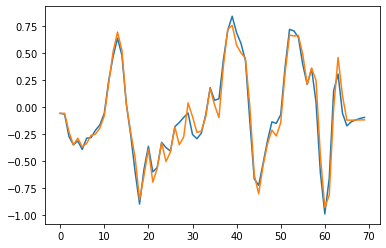

In [39]:
error_check,mean_check = check_dt(70,'l0',1,0,x1=-3000,x2=-1,input_pad=50,trigger_level=0.5, check=True,plotit=True)
print(error_check)

0.09949137


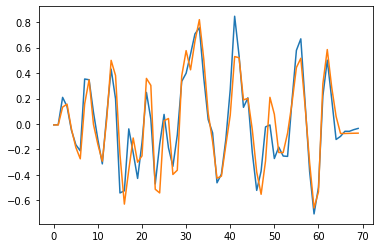

In [40]:
error_check,mean_check = check_dt(70,'l0iid',1,0,x1=-3000,x2=-1,input_pad=50,trigger_level=0.5, check=True,plotit=True)
print(error_check)

### Train with the digital twins

In [14]:
project_name = 'manifold_only_NLoscReDo_March17'

In [15]:
#Define the model parameters
base_name = '7C3L1C_T100_70D_L0_lr0p75_gap1_gw5_i196_arIC'
name=base_name + 'DT'
ir =59
               
Ncommittees=7
dims=[]
     #one more than layersgpusta
idts=[]
rot=[]
for idx in range(7):
    idts.append([1,1,1])
    dims.append([70,70,70,70])
    
    if np.mod(idx,2)==0:
        rot.append(True)
    else:
        rot.append(False)          
        
lr = 0.75 
gap=1
gwidth=5

lr = 0.75
milestones=[1,3,6,10,15,20,40] #schedA
milestones=[60]
gamma=0.75

In [16]:
import copy #We need this so the digital twins and the run_exps are independent even if they have the same parameters, for the local retraining later 

In [17]:
len_flist = len(dims)

full_dt_list1=list()
mean_dt_list1=list()
run_exp_list1=list()


for idn in range(len(dims)):

    for idl in range(len(dims[idn])-1):

        dtm1=copy.deepcopy(get_mean_dt(dims[idn][idl], dims[idn][idl+1],'l0',Tmaxs[idts[idn][idl]]))
        dtf1=get_full_dt(dtm1,dims[idn][idl], dims[idn][idl+1],'l0',Tmaxs[idts[idn][idl]])                
        pn1 = make_run_exp(dims[idn][idl],dims[idn][idl+1],'l0',idts[idn][idl],0,input_pad=50,trigger_level=0.5,check=True) 

        full_dt_list1.append(dtf1)
        mean_dt_list1.append(dtm1)
        run_exp_list1.append(pn1)
        


In [19]:
ptf_list1 = [generate_func(*fset) for fset in zip(run_exp_list1, mean_dt_list1)]

optimizer_name = 'Adadelta'

model_dt = ManifoldPlModelMNIST(full_dt_list1, dims,rot, lr,'cpu',optimizer_name,Ncommittees, gap,gwidth,identity=False,digital_twin=True, lag_amp=2.5, lag_factor=30.0,milestones=milestones,gamma=gamma)
model_dt.to("cpu");

model_exp = ManifoldPlModelMNIST(ptf_list1, dims,rot, lr,'cpu',optimizer_name,Ncommittees,gap,gwidth, identity=False,digital_twin=False, lag_amp=2.5, lag_factor=30.0,milestones=milestones,gamma=gamma)
model_exp.to("cpu");

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0

# Run model

In [20]:
initial_state = model_dt.state_dict()

Run the digital twin model first

In [21]:
#checkpointing stuff - to save the best model
csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name) #uses the same name that has been defined 2 cells above
logger = [csv_logger, wandb_logger]

In [22]:
##I find this is necessary sometimes to get the retrain and test callbacks to work - need to make sure directories exist
savepath=os.getcwd()+'\\'+csv_logger.log_dir  
if os.path.isdir(savepath) !=True:
    os.mkdir(savepath)

Get initial validation accuracy

In [23]:
from pytorch_lightning.metrics import Accuracy
import torch.nn.functional as F
from ana_lib.plot_utils import *

accu_metric = Accuracy()

In [24]:
def test_plmodel(plmodel, data_loader, Nrepeat=4):
    """
    Function that is helpful for evaluating a model multiple times in the presence of noise! 
    """
    accuracies = []
    losses = []
    outs= []
    for i in range(Nrepeat):
        print(i)
        for batch in data_loader:
            batch = [i.to(plmodel.device) for i in batch]
            with torch.no_grad():
                out = plmodel.validation_step(batch, 0)
            accuracies.append(out['val_accu'])
            losses.append(out['val_loss'])
            outs.append(out)
    return torch.stack(accuracies).cpu().numpy(), torch.stack(losses).cpu().numpy()

In [25]:
val_accuracies0,losses = test_plmodel(model_dt,val_loader,Nrepeat=4)
print(np.mean(val_accuracies0))

0
1
2
3
0.11445001


In [26]:
test_accuracies0,losses = test_plmodel(model_dt,test_loader,Nrepeat=4)
print(np.mean(test_accuracies0))

0
1
2
3
0.11540001


In [27]:
model_exp.load_state_dict(initial_state)

<All keys matched successfully>

In [28]:
#MAKE THIS SO IT RETRAINS DIGITAL TWINS FIRST!!!!

test_epoch = 1
test_cb = TestCallback_Classifier(test_epoch, test_loader, model_exp, model_dt, csv_logger.log_dir,
                       Nrepeat=3, test_name="dtt_exp", ref_name="dtt_dt") #the testing is done on the testing_dataset! 

val_epoch = 1
val_cb = TestCallback_Classifier(val_epoch, val_loader, model_exp, model_dt, csv_logger.log_dir,
                       Nrepeat=3, test_name="dtv_exp", ref_name="dtv_dt") #the testing is done on the testing_dataset! 

max_epoch =75
trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=None,
                     weights_summary=None, progress_bar_refresh_rate=0,
                     log_save_interval=100, row_log_interval=5,val_check_interval=0.1, callbacks=[test_cb]+[val_cb])
                   # )

trainer.fit(model_dt, train_loader, val_loader)
wandb_logger.experiment.join()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\jimiw\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\manifold_only_NLoscReDo_March17\7C3L1C_T100_70D_L0_lr0p75_gap1_gw5_i196_arICDT exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
wandb: Currently logged in as: pnn (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.0rc6
wandb: Run data is saved locally in wandb\run-20210317_190546-2e3dsfsf
wandb: Syncing run 7C3L1C_T100_70D_L0_lr0p75_gap1_gw5_i196_arICDT



Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
PNN failed
Missed run
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving model results
Saving mode

Saving latest checkpoint..
wandb: Waiting for W&B process to finish, PID 106208
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb\run-20210317_190546-2e3dsfsf\logs\debug.log
wandb: Find internal logs for this run at: wandb\run-20210317_190546-2e3dsfsf\logs\debug-internal.log
wandb: Run summary:
wandb:      global_step 44999
wandb:            epoch 74
wandb:     dtt_exp_accu 0.5166666507720947
wandb:     dtt_exp_loss 1.4833215475082397
wandb:      dtt_dt_accu 0.9700000286102295
wandb:      dtt_dt_loss 0.3471358120441437
wandb:            _step 9899
wandb:         _runtime 14116
wandb:       _timestamp 1616036463
wandb:     dtv_exp_accu 0.4899999797344208
wandb:     dtv_exp_loss 1.6790571212768555
wandb:      dtv_dt_accu 0.9099999666213989
wandb:      dtv_dt_loss 0.4511033594608307
wandb:    train_cr_loss 0.5309358835220337
wandb:   train_lag_loss 0.022510766983032227
wandb:       train_loss 0.5534466505050659
wandb:       train_accu 0.8300000429153442
wandb:      val_cr_loss 0.1763243

In [29]:
fname = 'RunMar17_homenew_with_manifold_Resnet_DT_model.p'

state_dict_dt = model_dt.state_dict()

save_dict = dict(state_dict_dt=state_dict_dt)#,val_accuracies0=val_accuracies0,test_accuracies0=test_accuracies0)

save_data = torch.save(save_dict, fname)

# Now train the equivalent linear digital model by setting PNN = identity

In [ ]:
name=base_name+'_identity'

model_I = ManifoldPlModelMNIST(full_dt_list1,dims,rot, lr,'cpu',optimizer_name,Ncommittees,gap,gwidth,identity=True,digital_twin=False, lag_amp=2.5, lag_factor=30.0,milestones=milestones,gamma=gamma)
model_I.to("cpu");

In [31]:
val_accuracies0,losses = test_plmodel(model_I,val_loader,Nrepeat=4)
print(np.mean(val_accuracies0))

0
1
2
3
0.1254


In [32]:
test_accuracies0,losses = test_plmodel(model_I,test_loader,Nrepeat=4)
print(np.mean(test_accuracies0))

0
1
2
3
0.1282


In [33]:
csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name) #uses the same name that has been defined 2 cells above
logger = [csv_logger, wandb_logger]

##I find this is necessary sometimes to get the retrain and test callbacks to work - need to make sure directories exist
savepath=os.getcwd()+'\\'+csv_logger.log_dir  
if os.path.isdir(savepath) !=True:
    os.mkdir(savepath)

max_epoch =50
trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=None,
                     weights_summary=None, progress_bar_refresh_rate=0,
                     log_save_interval=100, row_log_interval=5,val_check_interval=0.1)#, callbacks=[test_cb]+[val_cb])
                   # )

trainer.fit(model_I, train_loader, val_loader)
wandb_logger.experiment.join()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\jimiw\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\manifold_only_NLoscReDo_March17\7C3L1C_T100_70D_L0_lr0p75_gap1_gw5_i196_arIC_identity exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.0rc6
wandb: Run data is saved locally in wandb\run-20210317_230120-3rqf2dtv
wandb: Syncing run 7C3L1C_T100_70D_L0_lr0p75_gap1_gw5_i196_arIC_identity


Saving latest checkpoint..
wandb: Waiting for W&B process to finish, PID 106788
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb\run-20210317_230120-3rqf2dtv\logs\debug.log
wandb: Find internal logs for this run at: wandb\run-20210317_230120-3rqf2dtv\logs\debug-internal.log
wandb: Run summary:
wandb:      global_step 29999
wandb:    train_cr_loss 1.0681281089782715
wandb:   train_lag_loss 0.04303410276770592
wandb:       train_loss 1.1111621856689453
wandb:       train_accu 0.6399999856948853
wandb:            epoch 49
wandb:            _step 6499
wandb:         _runtime 2802
wandb:       _timestamp 1616039284
wandb:      val_cr_loss 0.7986295223236084
wandb:     val_lag_loss 0.03942929208278656
wandb:         val_loss 0.8380587697029114
wandb:         val_accu 0.711199939250946
wandb: Run history:
wandb:      global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:    train_cr_loss █▃▅▂▄▃▄▅▃▃▃▃▃▃▃▃▃▅▃▁▃▂▃▃▂▃▃▃▄▃▃▂▂▂▃▁▃▃▃▂
wandb:   train_lag_loss █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁

In [34]:
fname = 'RunMar17_home_identitymodel_MFonly.p'

state_dict_I = model_I.state_dict()

save_dict = dict(state_dict_I=state_dict_I,val_accuracies0=val_accuracies0,test_accuracies0=test_accuracies0)

save_data = torch.save(save_dict, fname)

# Now do the PAT PNN version

In [ ]:
model_exp = ManifoldPlModelMNIST(ptf_list1,  dims,rot, lr,'cpu',optimizer_name,Ncommittees,gap,gwidth,digital_twin=False, lag_amp=2.5, lag_factor=30.0,milestones=milestones,gamma=gamma)
model_exp.to("cpu");

In [36]:
name=base_name+'_EXP'

In [37]:
#model_dt.to("cpu"); #if working on a device with a gpu may need to do this

#checkpointing stuff - to save the best model
csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name) #uses the same name that has been defined above
logger = [csv_logger, wandb_logger]

##I find this is necessary sometimes to get the retrain and test callbacks to work - need to make sure directories exist
savepath=os.getcwd()+'\\'+csv_logger.log_dir  
if os.path.isdir(savepath) !=True:
    os.mkdir(savepath)

In [25]:
class RetrainCallbackLocal(Callback):
    """
    This retrainer retrains all digital twins based on their current inputs AND a consistent set of iid inputs 
    """
    def __init__(self, rt_epoch, rt_xlist, rt_trainer, rt_model, run_exp, ref_model,train_loader, idn,idl,Nbatches,Nchannels,Nlayers,savedir,name="dt_error",device ='cpu',plot_result=True):
        super().__init__()
        self.rt_epoch = rt_epoch
        self.rt_xlist = rt_xlist #this is the default data of iid inputs to use each time
        self.rt_trainer = rt_trainer #this is the trainer for the digital twin model 
        self.rt_model = rt_model #this is the model for the idn, idl digital twin. 
        #NOTE: some f(x) are the same digital twin model, but will be independently retrained due to different local data..
        self.run_exp = run_exp #this is the run_exp function for the idn, idl f(x)
        self.name = name
        print(name)
        self.ref_model =ref_model#this is the current total model of the PNN. Hiro, I pass this in as model_exp. I assume it will have the current parameter settings here, not the ones it had when it was sent in?
        self.idn = idn #channel number
        self.idl = idl #layer number   
        self.Nbatches = Nbatches #number of batches of training data to collect for DT retraining        
        self.Nchannels = Nchannels #number of channels in the model 
        self.Nlayers = Nlayers         
        self.train_loader = train_loader #needed to generate local data        
        self.savedir = savedir
        self.device = device
        self.plot_result = plot_result
  

    def on_train_epoch_start(self, trainer, pl_module):
        """Called when the train epoch begins."""
        epoch = trainer.current_epoch
        savedir = self.savedir
        rt_epoch = self.rt_epoch
        rt_xlist = self.rt_xlist #this is the default data of iid inputs 
        rt_trainer = self.rt_trainer
        rt_model = self.rt_model
        run_exp = self.run_exp
        idn = self.idn
        idl = self.idl
        device = self.device
        ref_model = self.ref_model
        plot_result = self.plot_result
        
        fname = os.path.join(savedir, f"RTdata_epoch_{epoch}.p") 
        if epoch % rt_epoch == 0:
            if (idn+idl)==0: #for the first channel/layer, acquire the local data
                               
                x= list()
                haha = iter(self.train_loader) #variable name in tribute to Tatsuhiro Onodera 
                for idx in range(self.Nbatches):
                    xc, yc = next(haha)
                    x.append(xc.to(device).detach().numpy())
                
                x = np.array(x)
                x = np.reshape(x,[x.shape[0]*x.shape[1],x.shape[2]]) #combine batches into a single input batch 
                #x[x>1]=1 #implement the clamp that will happen in the NN
                #x[x<-1]=-1  
                #add noise here
                y_hat = ref_model(torch.tensor(x).float(), save=True) #model saves xin and xout for each f(x)
                    
                xin=[]
                xout=[] 
                for xin_i in ref_model.xin:
                    xin.append(xin_i.detach().numpy())
                for xout_i in ref_model.xout:    
                    xout.append(xout_i.numpy())#ref_model.xout.numpy()
                
                save_dict = dict(xin=xin, xout=xout)
                
                save_data = torch.save(save_dict, fname)
                
            load_data = torch.load(fname) #for general idn, idl >0 load the acquired local data
            
            #Now perform retraining for the given f(x) indexed by idn, idl 
            xin_current = load_data['xin'][idn*self.Nlayers+idl]
            xout_current = load_data['xout'][idn*self.Nlayers+idl]
            
            rt_ylist = run_exp(torch.tensor(rt_xlist).float()).detach().numpy() #get the current output of the given f(x) for the iid inputs 
            
            x_train = np.vstack((xin_current,rt_xlist)) 
            y_train = np.vstack((xout_current,rt_ylist))
            #x_train = rt_xlist
            #y_train = rt_ylist         
            
           
            #shuffle 
            np.random.seed(1)
            inds=np.arange(x_train.shape[0])
            np.random.shuffle(inds)
            x_train = x_train[inds,:]
            y_train = y_train[inds]

            rt_train_loader, rt_val_loader = np2loaders(x_train, y_train, 
                                              train_ratio=0.9, Nbatch=100)
            
            #freze all parameters first, so that it doesn't retrain the whole model and overfit!
            for param in rt_model.parameters():
                param.requires_grad = False
            #unfreeze the l layers in the network
            for l in [-1, -2]:
                for param in rt_model.model.layers[l].parameters():
                    param.requires_grad = True
            
            rt_trainer.fit(rt_model, rt_train_loader, rt_val_loader)
            result = rt_trainer.test(rt_model, rt_val_loader)
            dt_error = result[0]['test_loss']
            metrics = dict(epoch=epoch)
            metrics[self.name] = dt_error
            trainer.logger.log_metrics(metrics, step=trainer.global_step)
            
            if plot_result == True:
                xt, yt = next(iter(rt_val_loader))
                with torch.no_grad():
                    y_pred = rt_model(xt)

                plot_grid(y_pred, yt, ylim=(-1.5, 1.5));
                plt.savefig(savedir + f"\\DTRTmean_epoch{epoch}_channel_{idn}_layer_{idl}.png", dpi=500)



class DebugCallback(Callback):
    """
    This callback saves, every epoch, the input-output of the PNN both for the training data and the validation data, so we can see how things evolve. 
    It does it for both the digital twin and the PNN, so we can see how they diverge
    """
    def __init__(self, debug_epoch, exp_model,dt_model,train_loader,val_loader,savedir,name="debug",device ='cpu'):
        super().__init__()
        self.debug_epoch = debug_epoch
        self.name = name
        print(name)
        self.exp_model =exp_model#this is the current total model of the PNN. Hiro, I pass this in as model_exp. I assume it will have the current parameter settings here, not the ones it had when it was sent in?
        self.dt_model = dt_model #this is the model with the digital twins instead
        self.train_loader = train_loader 
        self.val_loader = val_loader
        self.savedir = savedir
        self.device = device
        print(savedir)  

    def on_train_epoch_start(self, trainer, pl_module):
        """Called when the train epoch begins."""
        epoch = trainer.current_epoch
        savedir = self.savedir
        debug_epoch = self.debug_epoch
        device = self.device
        dt_model = self.dt_model
        exp_model = self.exp_model
        train_loader = self.train_loader
        val_loader = self.val_loader
        fname = os.path.join(savedir, f"Debugdata_epoch_{epoch}.p") 
        
        Nbatches = 2
               
        x = list() #store inputs
        y = list()
        haha = iter(self.train_loader)
        for idx in range(Nbatches):
            xc, yc = next(haha)
            x.append(xc.to(device).detach().numpy())
            y.append(yc.to(device).detach().numpy())

        x = np.array(x)
        x = np.reshape(x,[x.shape[0]*x.shape[1],x.shape[2]])
        y=np.array(y)
        y = np.reshape(y,[y.shape[0]*y.shape[1],])


        y_hat_exp = exp_model(torch.tensor(x).float(), save=True)           
        state_dict_exp = exp_model.state_dict()          
        dt_model.load_state_dict(state_dict_exp)            
        y_hat_dt = dt_model(torch.tensor(x).float(), save=True)

        xin_exp=exp_model.xin
        xout_exp=exp_model.xout

        xin_dt=dt_model.xin
        xout_dt=dt_model.xout

        ##now repeat above for validation
        xv = list() #store inputs
        yv = list()
        haha = iter(self.val_loader)
        for idx in range(Nbatches):
            xc, yc = next(haha)
            xv.append(xc.to(device).detach().numpy())
            yv.append(yc.to(device).detach().numpy())

        xv = np.array(xv)
        xv = np.reshape(xv,[xv.shape[0]*xv.shape[1],xv.shape[2]])
        yv=np.array(yv)
        yv = np.reshape(yv,[yv.shape[0]*yv.shape[1],])


        y_hat_exp = exp_model(torch.tensor(xv).float(), save=True)           
        state_dict_exp = exp_model.state_dict()          
        dt_model.load_state_dict(state_dict_exp)            
        y_hat_dt = dt_model(torch.tensor(xv).float(), save=True)

        xin_exp_v=exp_model.xin
        xout_exp_v=exp_model.xout

        xin_dt_v=dt_model.xin
        xout_dt_v=dt_model.xout           

        save_dict = dict(x=x,y=y,xin_dt=xin_dt, xout_dt=xout_dt,xin_exp=xin_exp,xout_exp=xout_exp,xv=xv,yv=yv,xin_dt_v=xin_dt_v, xout_dt_v=xout_dt_v,xin_exp_v=xin_exp_v,xout_exp_v=xout_exp_v,state_dict_exp=state_dict_exp,y_hat_dt=y_hat_dt,y_hat_exp=y_hat_exp)
        print('saving debug round' + fname)
        save_data = torch.save(save_dict, fname)
   

In [39]:
#Setup the debugging callback 
debug_epoch = 1          
debug_cb = DebugCallback(debug_epoch, model_exp,model_dt,train_loader,val_loader, csv_logger.log_dir)

debug
logs\manifold_only_NLoscReDo_March17\7C3L1C_T100_70D_L0_lr0p75_gap1_gw5_i196_arIC_EXP


In [43]:
#Setup the retraining callback for the first DT
retrain_epoch = 2 #do dt retraining every retrain_epochs
Nx = 5000 #number of iid x points for dt retraining
max_epoch = 5 #train for max_epoch epochs(go through that dt data 50 times)
Nbatches_for_retrain = 80 #number of batches of training data for the local training 

random.seed(10)

#make data for the retraining. The first layers need to have the MNIST data + parameters
retrain_xlist_list=list()
for idn in range(len(dims)):
    channel_list=list()
    #channel_list.append(random.uniform(-1.0, 1.0, [Nx, 98])) 
    for dim in dims[idn][0:-1]:
        channel_list.append(random.uniform(-1.0, 1.0, [Nx, dim])) 
        #channel_list.append(MNISTretraindata(dim,Nx))
    
    retrain_xlist_list.append(channel_list)


def make_retrain_trainer(channel_ind,layer_ind):
    csv_logger = pl.loggers.CSVLogger('logs', project_name, name+f"retrain_dt1_{channel_ind}_{layer_ind}")
    logger = [csv_logger]
    retrain_trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=None,
                         weights_summary=None, progress_bar_refresh_rate=0,
                         log_save_interval=10, row_log_interval=1)
    return retrain_trainer

retrain_trainer_list = list()
for idn in range(len(dims)):
    channel_list=list()
    idl=0
    for dim in dims[idn][0:-1]:
        channel_list.append(make_retrain_trainer(idn,idl))
        idl+=1
    retrain_trainer_list.append(channel_list)

retrain_cb_list1=list()
idl=0
for n in range(len(dims)):   
    for l in range(len(dims[n])-1):
        retrain_cb_list1.append(RetrainCallbackLocal(retrain_epoch, retrain_xlist_list[n][l], retrain_trainer_list[n][l], mean_dt_list1[idl], run_exp_list1[idl], model_exp,train_loader,n,l,Nbatches_for_retrain,len(dims),len(dims[0])-1,csv_logger.log_dir,name=f"dt1_error_{n}_{l}"))
        idl+=1

        

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, use

dt1_error_0_0
dt1_error_0_1
dt1_error_0_2
dt1_error_1_0
dt1_error_1_1
dt1_error_1_2
dt1_error_2_0
dt1_error_2_1
dt1_error_2_2
dt1_error_3_0
dt1_error_3_1
dt1_error_3_2
dt1_error_4_0
dt1_error_4_1
dt1_error_4_2
dt1_error_5_0
dt1_error_5_1
dt1_error_5_2
dt1_error_6_0
dt1_error_6_1
dt1_error_6_2


In [44]:
#Setup the testing callback 
test_epoch = 1
test_cb = TestCallback_Classifier(test_epoch, test_loader, model_dt, model_exp, csv_logger.log_dir,
                       Nrepeat=3, test_name="pat_dt", ref_name="pat_exp") #just for curiousity look at how digital twin would do with parameters from experiment!

In [ ]:
max_epoch = 200
trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=None,
                     weights_summary=None, progress_bar_refresh_rate=0,
                     log_save_interval=100, row_log_interval=5,val_check_interval=0.1,callbacks=retrain_cb_list1+[debug_cb]+[test_cb])

trainer.fit(model_exp, train_loader, val_loader)
wandb_logger.experiment.join()

In [46]:
fname = 'RunMar17_EXP_model.p'

state_dict_exp = model_exp.state_dict()

save_dict = dict(state_dict_exp=state_dict_exp)#,val_accuracies0=val_accuracies0,test_accuracies0=test_accuracies0)

save_data = torch.save(save_dict, fname)

In [38]:
state_dict_exp = torch.load('RunMar17_EXP_model.p')['state_dict_exp']

In [40]:
name=base_name+'_EXP_lr2'
lr = 0.375
milestones = [15,30]
gamma=0.75

In [ ]:
model_exp2 = ManifoldPlModelMNIST(ptf_list1,  dims,rot, lr,'cpu',optimizer_name,Ncommittees,gap,gwidth,digital_twin=False, lag_amp=2.5, lag_factor=30.0,milestones=milestones,gamma=gamma)
model_exp2.to("cpu");

In [42]:
model_exp2.load_state_dict(state_dict_exp)

<All keys matched successfully>

In [44]:
model_exp2.lr = 0.375
model_exp2.milestones = [10,20,30]
model_exp2.gamma =0.75

In [45]:
#model_dt.to("cpu"); #if working on a device with a gpu may need to do this

#checkpointing stuff - to save the best model
csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name) #uses the same name that has been defined above
logger = [csv_logger, wandb_logger]

##I find this is necessary sometimes to get the retrain and test callbacks to work - need to make sure directories exist
savepath=os.getcwd()+'\\'+csv_logger.log_dir  
if os.path.isdir(savepath) !=True:
    os.mkdir(savepath)

In [46]:
#Setup the debugging callback 
debug_epoch = 1          
debug_cb = DebugCallback(debug_epoch, model_exp2,model_dt,train_loader,val_loader, csv_logger.log_dir)

debug
logs\manifold_only_NLoscReDo_March17\7C3L1C_T100_70D_L0_lr0p75_gap1_gw5_i196_arIC_EXP_lr2


In [ ]:
#MORE LOCAL training

class RetrainCallbackLocal(Callback):
    """
    This retrainer retrains all digital twins based on their current inputs AND a consistent set of iid inputs 
    """
    def __init__(self, rt_epoch, rt_xlist, rt_trainer, rt_model, run_exp, ref_model,train_loader, idn,idl,Nbatches,Nchannels,Nlayers,savedir,name="dt_error",device ='cpu',plot_result=True):
        super().__init__()
        self.rt_epoch = rt_epoch
        self.rt_xlist = rt_xlist #this is the default data of iid inputs to use each time
        self.rt_trainer = rt_trainer #this is the trainer for the digital twin model 
        self.rt_model = rt_model #this is the model for the idn, idl digital twin. 
        #NOTE: some f(x) are the same digital twin model, but will be independently retrained due to different local data..
        self.run_exp = run_exp #this is the run_exp function for the idn, idl f(x)
        self.name = name
        print(name)
        self.ref_model =ref_model#this is the current total model of the PNN. Hiro, I pass this in as model_exp. I assume it will have the current parameter settings here, not the ones it had when it was sent in?
        self.idn = idn #channel number
        self.idl = idl #layer number   
        self.Nbatches = Nbatches #number of batches of training data to collect for DT retraining        
        self.Nchannels = Nchannels #number of channels in the model 
        self.Nlayers = Nlayers         
        self.train_loader = train_loader #needed to generate local data        
        self.savedir = savedir
        self.device = device
        self.plot_result = plot_result
  

    def on_train_epoch_start(self, trainer, pl_module):
        """Called when the train epoch begins."""
        epoch = trainer.current_epoch
        savedir = self.savedir
        rt_epoch = self.rt_epoch
        rt_xlist = self.rt_xlist #this is the default data of iid inputs 
        rt_trainer = self.rt_trainer
        rt_model = self.rt_model
        run_exp = self.run_exp
        idn = self.idn
        idl = self.idl
        device = self.device
        ref_model = self.ref_model
        plot_result = self.plot_result
        
        fname = os.path.join(savedir, f"RTdata_epoch_{epoch}.p") 
        if epoch % rt_epoch == 0:
            if (idn+idl)==0: #for the first channel/layer, acquire the local data
                               
                x= list()
                haha = iter(self.train_loader) #variable name in tribute to Tatsuhiro Onodera 
                for idx in range(self.Nbatches):
                    xc, yc = next(haha)
                    x.append(xc.to(device).detach().numpy())
                
                x = np.array(x)
                x = np.reshape(x,[x.shape[0]*x.shape[1],x.shape[2]]) #combine batches into a single input batch 
                #x[x>1]=1 #implement the clamp that will happen in the NN
                #x[x<-1]=-1  
                #add noise here
                y_hat = ref_model(torch.tensor(x).float(), save=True) #model saves xin and xout for each f(x)
                    
                xin=[]
                xout=[] 
                for xin_i in ref_model.xin:
                    xin.append(xin_i.detach().numpy())
                for xout_i in ref_model.xout:    
                    xout.append(xout_i.numpy())#ref_model.xout.numpy()
                
                save_dict = dict(xin=xin, xout=xout)
                
                save_data = torch.save(save_dict, fname)
                
            load_data = torch.load(fname) #for general idn, idl >0 load the acquired local data
            
            #Now perform retraining for the given f(x) indexed by idn, idl 
            xin_current = load_data['xin'][idn*self.Nlayers+idl]
            xout_current = load_data['xout'][idn*self.Nlayers+idl]
            
            rt_ylist = run_exp(torch.tensor(rt_xlist).float()).detach().numpy() #get the current output of the given f(x) for the iid inputs 
            
            x_train = np.vstack((xin_current,rt_xlist)) 
            y_train = np.vstack((xout_current,rt_ylist))
            #x_train = rt_xlist
            #y_train = rt_ylist         
            
           
            #shuffle 
            np.random.seed(1)
            inds=np.arange(x_train.shape[0])
            np.random.shuffle(inds)
            x_train = x_train[inds,:]
            y_train = y_train[inds]

            rt_train_loader, rt_val_loader = np2loaders(x_train, y_train, 
                                              train_ratio=0.9, Nbatch=100)
            
            #freze all parameters first, so that it doesn't retrain the whole model and overfit!
            #for param in rt_model.parameters():
            #    param.requires_grad = False
            #unfreeze the l layers in the network
            #for l in [-1, -2]:
            #    for param in rt_model.model.layers[l].parameters():
            #        param.requires_grad = True
            
            rt_trainer.fit(rt_model, rt_train_loader, rt_val_loader)
            result = rt_trainer.test(rt_model, rt_val_loader)
            dt_error = result[0]['test_loss']
            metrics = dict(epoch=epoch)
            metrics[self.name] = dt_error
            trainer.logger.log_metrics(metrics, step=trainer.global_step)
            
            if plot_result == True:
                xt, yt = next(iter(rt_val_loader))
                with torch.no_grad():
                    y_pred = rt_model(xt)

                plot_grid(y_pred, yt, ylim=(-1.5, 1.5));
                plt.savefig(savedir + f"\\DTRTmean_epoch{epoch}_channel_{idn}_layer_{idl}.png", dpi=500)


#Setup the retraining callback for the first DT
retrain_epoch = 2 #do dt retraining every retrain_epochs
Nx = 1000 #number of iid x points for dt retraining
max_epoch = 5 #train for max_epoch epochs(go through that dt data 50 times)
Nbatches_for_retrain = 100 #number of batches of training data for the local training 

random.seed(10)

#make data for the retraining. The first layers need to have the MNIST data + parameters
retrain_xlist_list=list()
for idn in range(len(dims)):
    channel_list=list()
    #channel_list.append(random.uniform(-1.0, 1.0, [Nx, 98])*0.5) 
    for dim in dims[idn][0:-1]:
        channel_list.append(random.uniform(-1.0, 1.0, [Nx, dim])) 
        #channel_list.append(MNISTretraindata(dim,Nx))
    
    retrain_xlist_list.append(channel_list)


def make_retrain_trainer(channel_ind,layer_ind):
    csv_logger = pl.loggers.CSVLogger('logs', project_name, name+f"retrain_dt1_{channel_ind}_{layer_ind}")
    logger = [csv_logger]
    retrain_trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=None,
                         weights_summary=None, progress_bar_refresh_rate=0,
                         log_save_interval=10, row_log_interval=1)
    return retrain_trainer

retrain_trainer_list = list()
for idn in range(len(dims)):
    channel_list=list()
    idl=0
    for dim in dims[idn][0:-1]:
        channel_list.append(make_retrain_trainer(idn,idl))
        idl+=1
    retrain_trainer_list.append(channel_list)

retrain_cb_list1=list()
idl=0
for n in range(len(dims)):   
    for l in range(len(dims[n])-1):
        retrain_cb_list1.append(RetrainCallbackLocal(retrain_epoch, retrain_xlist_list[n][l], retrain_trainer_list[n][l], mean_dt_list1[idl], run_exp_list1[idl], model_exp2,train_loader,n,l,Nbatches_for_retrain,len(dims),len(dims[0])-1,csv_logger.log_dir,name=f"dt1_error_{n}_{l}"))
        idl+=1

        

In [48]:
#Setup the testing callback 
test_epoch = 1
test_cb = TestCallback_Classifier(test_epoch, test_loader, model_dt, model_exp2, csv_logger.log_dir,
                       Nrepeat=3, test_name="pat_dt", ref_name="pat_exp") #just for curiousity look at how digital twin would do with parameters from experiment!

In [ ]:
max_epoch = 200
trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=None,
                     weights_summary=None, progress_bar_refresh_rate=0,
                     log_save_interval=100, row_log_interval=5,val_check_interval=0.1,callbacks=retrain_cb_list1+[debug_cb]+[test_cb])

trainer.fit(model_exp2, train_loader, val_loader)
wandb_logger.experiment.join()

In [50]:
fname = 'RunMar23_EXP_model.p'

state_dict_exp = model_exp2.state_dict()

save_dict = dict(state_dict_exp=state_dict_exp)#,val_accuracies0=val_accuracies0,test_accuracies0=test_accuracies0)

save_data = torch.save(save_dict, fname)

# Analysis and saving data

In [51]:
from pytorch_lightning.metrics import Accuracy
import torch.nn.functional as F
from ana_lib.plot_utils import *

accu_metric = Accuracy()

In [52]:
def test_plmodel(plmodel, data_loader, Nrepeat=4):
    """
    Function that is helpful for evaluating a model multiple times in the presence of noise! 
    """
    accuracies = []
    losses = []
    outs= []
    for i in range(Nrepeat):
        print(i)
        for batch in data_loader:
            batch = [i.to(plmodel.device) for i in batch]
            with torch.no_grad():
                out = plmodel.validation_step(batch, 0)
            accuracies.append(out['val_accu'])
            losses.append(out['val_loss'])
            outs.append(out)
    return torch.stack(accuracies).cpu().numpy(), torch.stack(losses).cpu().numpy(), outs

In [53]:
accuracies,losses,outs = test_plmodel(model_exp2,test_loader,Nrepeat=4)

0
length error_94
PNN failed
Missed run
PNN failed
Missed run
PNN failed
Missed run
PNN failed
Missed run
length error_96
PNN failed
Missed run
length error_99
PNN failed
Missed run
PNN failed
Missed run
1
length error_98
PNN failed
Missed run
PNN failed
Missed run
PNN failed
Missed run
length error_100
PNN failed
Missed run
length error_98
PNN failed
Missed run
2
length error_100
PNN failed
Missed run
3
length error_95
PNN failed
Missed run
length error_100
PNN failed
Missed run
length error_98
PNN failed
Missed run


In [54]:
np.mean(accuracies)

0.92289996

In [58]:
fname = 'RunMarch23_test_EXP.p'

state_dict_exp = model_exp2.state_dict()

save_dict = dict(state_dict_exp=state_dict_exp,test_loader=test_loader,losses=losses,accuracies=accuracies)

save_data = torch.save(save_dict, fname)

In [59]:
fname = 'RunMarch23_test_EXP'

tensor(0.9470)
tensor(0.9215)
tensor(0.9310)


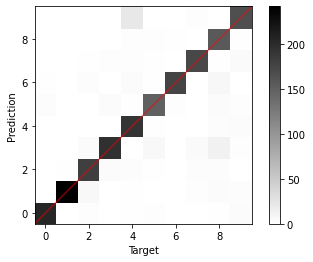

In [60]:
##Training data
Nbatches = 20
device='cpu'

x = list() #store inputs
y = list()    
dataloader_iterator = iter(val_loader)  #This somewhat complicated scheme is necessary to get different batches
for i in range(Nbatches):
    try:
        data, target = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        data, target = next(dataloader_iterator)
    x.append(data.to(device).detach().numpy())
    y.append(target.to(device).detach().numpy()) 

x = np.array(x)
x = np.reshape(x,[x.shape[0]*x.shape[1],x.shape[2]])
y=np.array(y)
y = np.reshape(y,[y.shape[0]*y.shape[1],])

y_hat_exp = model_exp2(torch.tensor(x).float(), save=True)           
state_dict_exp = model_exp2.state_dict()          
model_dt.load_state_dict(state_dict_exp)            
y_hat_dt = model_dt(torch.tensor(x).float(), save=True)

xin_exp=model_exp2.xin
xout_exp=model_exp2.xout

xin_dt=model_dt.xin
xout_dt=model_dt.xout

save_dict = dict(x=x,y=y,xin_dt=xin_dt, xout_dt=xout_dt,xin_exp=xin_exp,xout_exp=xout_exp,state_dict_exp=state_dict_exp,y_hat_dt=y_hat_dt,y_hat_exp=y_hat_exp)
fnamec = 'Training_' +fname
save_data = torch.save(save_dict, fnamec)


data = torch.load(fnamec)
    
y_pred_exp = torch.max(data['y_hat_exp'].data,1)[1]
    
y_pred_dt = torch.max(data['y_hat_dt'].data,1)[1]
    
y = data['y']
    
accuracy_exp_dt = accu_metric(y_pred_exp, y_pred_dt)
print(accuracy_exp_dt)    

accuracy_exp_test = accu_metric(y_pred_exp, y)
print(accuracy_exp_test)

accuracy_dt_test = accu_metric(y_pred_dt, y)
print(accuracy_dt_test)



target = y 
pred = y_pred_exp

import sklearn.metrics as metric
conf = metric.confusion_matrix(target, pred)
axis = np.arange(0.0, 9.1)
plt.figure(figsize=(5,4))
pcolormesh_center(axis, axis, conf, cmap="binary")
plt.colorbar()
plt.plot([-10, 10], [-10, 10], color="r", alpha=0.5)
plt.axis('square')
plt.xlim(-0.5, 9.5)
plt.ylim(-0.5, 9.5)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.savefig('TrainingConfusion.pdf')

In [ ]:
##now repeat above for validation set
device='cpu'
Nbatches = 40

xv = list() #store inputs
yv = list()    
dataloader_iterator = iter(val_loader)  #This somewhat complicated scheme is necessary to get different batches
for i in range(Nbatches):
    try:
        data, target = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        data, target = next(dataloader_iterator)
    xv.append(data.to(device).detach().numpy())
    yv.append(target.to(device).detach().numpy()) 
    #print(target)
    
    
xv = np.array(xv)
xv = np.reshape(xv,[xv.shape[0]*xv.shape[1],xv.shape[2]])
yv=np.array(yv)
yv = np.reshape(yv,[yv.shape[0]*yv.shape[1],])
plt.plot(yv)

y_hat_exp = model_exp2(torch.tensor(xv).float(), save=True)           
state_dict_exp = model_exp2.state_dict()          
model_dt.load_state_dict(state_dict_exp)            
y_hat_dt = model_dt(torch.tensor(xv).float(), save=True)

xin_exp_v=model_exp2.xin
xout_exp_v=model_exp2.xout

xin_dt_v=model_dt.xin
xout_dt_v=model_dt.xout            

save_dict = dict(xv=xv,yv=yv,xin_dt_v=xin_dt_v, xout_dt_v=xout_dt_v,xin_exp_v=xin_exp_v,xout_exp_v=xout_exp_v,state_dict_exp=state_dict_exp,y_hat_dt=y_hat_dt,y_hat_exp=y_hat_exp)
fnamec = 'Validation_' +fname
save_data = torch.save(save_dict, fnamec)



data = torch.load(fnamec)
    
y_pred_exp = torch.max(data['y_hat_exp'].data,1)[1]
    
y_pred_dt = torch.max(data['y_hat_dt'].data,1)[1]
    
y = data['yv']
    
accuracy_exp_dt = accu_metric(y_pred_exp, y_pred_dt)
print(accuracy_exp_dt)    

accuracy_exp_test = accu_metric(y_pred_exp, y)
print(accuracy_exp_test)

accuracy_dt_test = accu_metric(y_pred_dt, y)
print(accuracy_dt_test)

In [ ]:
target = y 
pred = y_pred_exp.detach().numpy()

import sklearn.metrics as metric
conf = metric.confusion_matrix(target, pred)
print(conf.shape)
axis = np.arange(0.0, 9.1)
plt.figure(figsize=(5,4))
pcolormesh_center(axis, axis, conf, cmap="binary")
plt.colorbar()
plt.plot([-10, 10], [-10, 10], color="r", alpha=0.5)
plt.axis('square')
plt.xlim(-0.5, 9.5)
plt.ylim(-0.5, 9.5)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.savefig('ValidationConfusion.pdf')

In [ ]:
plt.plot(target)
plt.xlim(0,100)

In [ ]:
pred.shape

tensor(0.9532)
tensor(0.9272)
tensor(0.9337)


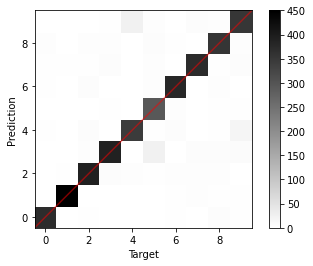

In [62]:
##now repeat above for test set
xt = list() #store inputs
yt = list()    
dataloader_iterator = iter(test_loader)  #This somewhat complicated scheme is necessary to get different batches
for i in range(Nbatches):
    try:
        data, target = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        data, target = next(dataloader_iterator)
    xt.append(data.to(device).detach().numpy())
    yt.append(target.to(device).detach().numpy()) 

xt = np.array(xt)
xt = np.reshape(xt,[xt.shape[0]*xt.shape[1],xt.shape[2]])
yt=np.array(yt)
yt = np.reshape(yt,[yt.shape[0]*yt.shape[1],])


y_hat_exp = model_exp2(torch.tensor(xt).float(), save=True)           
state_dict_exp = model_exp2.state_dict()          
model_dt.load_state_dict(state_dict_exp)            
y_hat_dt = model_dt(torch.tensor(xt).float(), save=True)

xin_exp_t=model_exp2.xin
xout_exp_t=model_exp2.xout

xin_dt_t=model_dt.xin
xout_dt_t=model_dt.xout            

save_dict = dict(xt=xt,yt=yt,xin_dt_t=xin_dt_t, xout_dt_t=xout_dt_t,xin_exp_t=xin_exp_t,xout_exp_t=xout_exp_t,state_dict_exp=state_dict_exp,y_hat_dt=y_hat_dt,y_hat_exp=y_hat_exp)
fnamec = 'Test_' + fname
save_data = torch.save(save_dict, fnamec)




data = torch.load(fnamec)
    
y_pred_exp = torch.max(data['y_hat_exp'].data,1)[1]
    
y_pred_dt = torch.max(data['y_hat_dt'].data,1)[1]
    
y = data['yt']
    
accuracy_exp_dt = accu_metric(y_pred_exp, y_pred_dt)
print(accuracy_exp_dt)    

accuracy_exp_test = accu_metric(y_pred_exp, y)
print(accuracy_exp_test)

accuracy_dt_test = accu_metric(y_pred_dt, y)
print(accuracy_dt_test)




target = y 
pred = y_pred_exp.detach().numpy()

import sklearn.metrics as metric
conf = metric.confusion_matrix(target, pred)
axis = np.arange(0.0, 9.1)
plt.figure(figsize=(5,4))
pcolormesh_center(axis, axis, conf, cmap="binary")
plt.colorbar()
plt.plot([-10, 10], [-10, 10], color="r", alpha=0.5)
plt.axis('square')
plt.xlim(-0.5, 9.5)
plt.ylim(-0.5, 9.5)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.savefig('TestConfusion.pdf')

# Collect data for the supplementary with a version that saves more

In [85]:
class ManifoldPlModelMNIST(ClassificationLagPlModel):
    def __init__(self, flist1, dims,rot,lr,device,optimizer_name,N_committees, gap,gwidth,identity=False,digital_twin=True,lag_amp=2.5, lag_factor=30.0,milestones=[10,20,30,40,50,60,70],gamma=0.5):
        super().__init__()
              
        self.save_hyperparameters()
        #delete flist since it is a function which cannot be saved as JSON and will cause a bug...
        del self.hparams["flist1"] 
             # writing more attributes to hyperparams that will appear on wandb
        for (i, Nunit) in enumerate(dims):
            self.hparams[f'ldim_{i}'] = Nunit
        self.hparams['Nlayers'] = len(dims[0])  #adding Nlayers
        self.hparams['Nchannels'] = len(dims)//N_committees 
        self.hparams['gap'] = 2
        self.N_committees = N_committees
        self.hparams['optimizer']= optimizer_name
        self.factors1 = nn.ParameterList()
        self.offsets1 = nn.ParameterList()     
        self.factors2 = nn.ParameterList()
        self.offsets2 = nn.ParameterList() 
        self.dims = dims
        self.rot = rot
        #self.ils = nn.ModuleList()
        #self.Ms = list()
        self.output_scale = nn.Parameter(torch.ones(1))
        self.output_offset  = nn.Parameter(torch.zeros(1))   

        self.skip_weight=nn.ParameterList()
        self.digital_twin=digital_twin
        self.identity=identity
        self.milestones=milestones
        self.gamma=gamma
        self.lr=lr

        N_channels = len(dims)
        self.N_channels = N_channels
        N_layers = len(dims[0])-1
        self.N_layers = N_layers
       
        N_channels_per = len(dims)//N_committees         
    
        dim_out = 0
        for n in range(N_channels):
            nlayers = len(flist1)        
            for l in range(N_layers):
                dim=dims[n][l]
                if l==0:
                    self.factors1.append(nn.Parameter(torch.ones(196)*1.))
                    self.offsets1.append(nn.Parameter(torch.zeros(196)))                
                else:
                    self.factors1.append(nn.Parameter(torch.randn(dim)*0.5))
                    self.offsets1.append(nn.Parameter(torch.zeros(dim)))                               
                
                self.skip_weight.append(nn.Parameter(torch.ones(1)*1.25))
            
        self.flist1 = flist1

        self.xPLMs = []
        
        self.gap=gap
        self.en=gap+int(gwidth)*10
                                            
        self.IL = torch.zeros([196,dims[0][1]//5],requires_grad=False).float().to(device) 
        
        n2=0
        for n1 in range(196):         
            if np.mod(n1,196//(dims[0][1]//5)) == 0 and n1 !=0:
                n2+=1               
            self.IL[n1,n2]=1
        print(self.IL)     
                
        
        self.OL = torch.zeros([10*int(gwidth)*N_channels_per,10],requires_grad=False).float().to(device) 
        
        n2=0
        for n1 in range(10*int(gwidth)*N_channels_per):         
            if np.mod(n1,10*int(gwidth)*N_channels_per//10) == 0 and n1 !=0:
                n2+=1               
            self.OL[n1,n2]=1
        print(self.OL)     
        
        self.channel_weight = nn.ParameterList() 
        for n in range(N_channels):
            self.channel_weight.append(nn.Parameter(torch.ones(1)))
            
        self.channel_offset = nn.ParameterList() 
        for n in range(N_channels):
            self.channel_offset.append(nn.Parameter(torch.zeros(1)))            
                
    def forward(self, x, save=False):
        
        self.xin = []
        self.xout = []
        self.xskip = []
        self.xoutf = []
        self.xfinal = []
            
        #bnldx=0
        x0=torch.roll(x,-20,1)-0.4
        #x0=torch.matmul(x0,self.IL)
        #x0 =torch.cat([x0,x0,x0,x0,x0],dim=1) #70
        fdx=0
        nc=0
        for n in range(self.N_channels):
            
            for l in range(self.N_layers):        
                ldx=l+n*self.N_layers
                if l==0:
                    x=x0*self.factors1[ldx]+self.offsets1[ldx]
                    xskip1 = torch.matmul(x,self.IL)   #From 196 to 14
                    x=torch.matmul(x,self.IL) #from 196 to 14
                    x=torch.cat([x,x,x,x,x],dim=1) #70
                    xskip1=torch.cat([xskip1,xskip1,xskip1,xskip1,xskip1],dim=1) #70
                                       
                    self.xin.append(x) #MODIFIED FOR THE LAGRANGIAN
                    x = x.clamp(-1, 1)
                    if self.identity==False:
                        x = self.flist1[ldx](x)
                    self.xout.append(x.detach())    
                    x=x+self.skip_weight[fdx]*xskip1
                    
                    xtemp=self.skip_weight[fdx]*xskip1
                    self.xskip.append(xtemp.detach())
                    
                else:
                    x=x*self.factors1[ldx]+self.offsets1[ldx]
                    xskip1 = x  #From 196 to 28
                    self.xin.append(x) #MODIFIED FOR THE LAGRANGIAN
                    x = x.clamp(-1, 1)
                    if self.identity==False:
                        x = self.flist1[ldx](x)
                    self.xout.append(x.detach())
                                     
                    x=x+self.skip_weight[fdx]*xskip1 
                    
                    xtemp=self.skip_weight[fdx]*xskip1
                    self.xskip.append(xtemp.detach())                   

            if nc==0:
                xout=x[:,self.gap:self.en]*self.channel_weight[n]+self.channel_offset[n]
                xtemp=torch.matmul(xout,self.OL)
                self.xoutf.append(xtemp.detach())
            else:
                xout=torch.cat([xout,x[:,self.gap:self.en]*self.channel_weight[n]+self.channel_offset[n]],dim=1)                                  
                
            nc+=1
            if nc%(self.N_channels//self.N_committees)==0:
                if n==self.N_channels//self.N_committees-1:
                    xoutf=torch.matmul(xout,self.OL)
                else:
                    xoutf+=torch.matmul(xout,self.OL)
                nc=0
                

        x = self.output_scale*xoutf+self.output_offset  
        self.xfinal.append(x.detach())
        return x
 
    def lagrangian(self):
        """
        The lagrangian function that will be added to the loss.
        """
        if self.digital_twin == True:
            lag_layers = [self.hparams.lag_amp*clamp_lag(x, -0.9, 0.9, self.hparams.lag_factor) for x in self.xin]
        else:
            lag_layers = [self.hparams.lag_amp*clamp_lag(x, -1., 1., self.hparams.lag_factor) for x in self.xin]
        #use stack to convert python list to pytorch tensor, then take the mean
        out = torch.mean(torch.stack(lag_layers))
        return out    
          
    def configure_optimizers(self):
        optimizer = optim.Adadelta(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
        return [optimizer], [scheduler]    

In [ ]:
model_exp3 = ManifoldPlModelMNIST(ptf_list1,  dims,rot, lr,'cpu',optimizer_name,Ncommittees,gap,gwidth,digital_twin=False, lag_amp=2.5, lag_factor=30.0,milestones=milestones,gamma=gamma)
model_exp3.to("cpu");

In [87]:
state_dict_exp = torch.load('RunMar23_EXP_model.p')['state_dict_exp']

In [88]:
model_exp3.load_state_dict(state_dict_exp)

<All keys matched successfully>

In [89]:
xt = list() #store inputs
yt = list()    
dataloader_iterator = iter(val_loader)  #This somewhat complicated scheme is necessary to get different batches
for i in range(Nbatches):
    try:
        data, target = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        data, target = next(dataloader_iterator)
    xt.append(data.to(device).detach().numpy())
    yt.append(target.to(device).detach().numpy()) 

xt = np.array(xt)
xt = np.reshape(xt,[xt.shape[0]*xt.shape[1],xt.shape[2]])
yt=np.array(yt)
yt = np.reshape(yt,[yt.shape[0]*yt.shape[1],])


y_hat_exp = model_exp3(torch.tensor(xt).float(), save=True)           
state_dict_exp = model_exp3.state_dict()          
model_dt.load_state_dict(state_dict_exp)            
y_hat_dt = model_dt(torch.tensor(xt).float(), save=True)

xin_exp_t=model_exp3.xin
xout_exp_t=model_exp3.xout

xin_dt_t=model_dt.xin
xout_dt_t=model_dt.xout            

save_dict = dict(xt=xt,yt=yt,xin_dt_t=xin_dt_t, xout_dt_t=xout_dt_t,xin_exp_t=xin_exp_t,xout_exp_t=xout_exp_t,state_dict_exp=state_dict_exp,y_hat_dt=y_hat_dt,y_hat_exp=y_hat_exp)
fnamec = 'TestF_' + fname
save_data = torch.save(save_dict, fnamec)


data = torch.load(fnamec)
    
y_pred_exp = torch.max(data['y_hat_exp'].data,1)[1]
    
y_pred_dt = torch.max(data['y_hat_dt'].data,1)[1]
    
y = data['yt']
    
accuracy_exp_dt = accu_metric(y_pred_exp, y_pred_dt)
print(accuracy_exp_dt)    

accuracy_exp_test = accu_metric(y_pred_exp, y)
print(accuracy_exp_test)

accuracy_dt_test = accu_metric(y_pred_dt, y)
print(accuracy_dt_test)

tensor(0.9538)
tensor(0.9268)
tensor(0.9277)


In [90]:
xin = model_exp3.xin
xout = model_exp3.xout
xoutf = model_exp3.xoutf
xskip = model_exp3.xskip
xfinal = model_exp3.xfinal

In [91]:
len(xskip)

21

In [92]:
xskip[0].shape

torch.Size([4000, 70])

In [93]:
save_dict = dict(xin = xin, xout = xout, xskip=xskip,xoutf=xoutf,xfinal=xfinal,xt=xt,yt=yt, state_dict_exp = state_dict_exp) 
fnamec = 'Test_fullsave_' + fname
save_data = torch.save(save_dict, fnamec)